# Import modules

In [1]:
%%time

import datetime
import os, glob, sys
import warnings
warnings.filterwarnings('ignore', '.*invalid value encountered in true_divide.*', )

import pickle

import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs       as ccrs
import cartopy
from matplotlib.colors import ListedColormap
from matplotlib import cm


from scipy.interpolate import UnivariateSpline
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from scipy.stats import pearsonr, spearmanr

mpl.rcParams['savefig.dpi'] = 300

CPU times: user 1.2 s, sys: 167 ms, total: 1.37 s
Wall time: 1.39 s


# Input parameters

In [2]:
%%time
print(datetime.datetime.now())

dirroot    =  '/mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/'
dirshared  = dirroot + 'SHARED-DATAS/'
dircmip6   = dirroot + 'CMIP6-DATAS-LINKS/'


2022-12-05 17:56:17.554533
CPU times: user 62 µs, sys: 10 µs, total: 72 µs
Wall time: 78 µs


# Starters

In [3]:
%%time
print(datetime.datetime.now())

dirout = dirroot + 'dimred-220708-figure-article-v0/'
if not os.path.isdir(dirout) : os.mkdir(dirout)

2022-12-05 17:56:17.884577
CPU times: user 0 ns, sys: 418 µs, total: 418 µs
Wall time: 234 µs


In [4]:
%%time
print(datetime.datetime.now())
sys.stdout.echo = open(dirout+'stdout.txt', 'w')
sys.stderr.echo = open(dirout+'stderr.txt', 'w')

2022-12-05 17:56:18.189524
CPU times: user 1.72 ms, sys: 0 ns, total: 1.72 ms
Wall time: 3.54 ms


# Define figure parameters

In [5]:
mpl.rcParams['font.size'] = 8
cm2in = 1/2.54

# Maps score KR

## Inputs

In [15]:
%%time
print(datetime.datetime.now())
print('Maps score KR: inputs')

data2plot_dir = dirroot + 'dimred-220602-score-analysis/'
grid  = '360x180'
data2plot_file = data2plot_dir+'data2plot-maps-score-KR-'+grid+'.pckl'

# model_list = ['NorESM2-LM', 'MPI-ESM1-2-LR', 'CNRM-ESM2-1', 'CESM2', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR']
model_list = ['ACCESS-ESM1-5', 'CESM2', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'NorESM2-LM']
simu_list  = ['picontrol', 'historical', 'ssp126', 'ssp585']
#grid_list  = ['90x45', '180x90']

simu_name = {
    'picontrol': 'preindustrial', 
    'historical': 'historical', 
    'ssp126': 'SSP126', 
    'ssp585': 'SSP585'
}


2022-12-05 18:01:24.738793
Maps score KR: inputs
CPU times: user 349 µs, sys: 0 ns, total: 349 µs
Wall time: 218 µs


## Fig

2022-12-05 18:01:31.671421
Maps score KR: fig
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/dimred-220602-score-analysis/data2plot-maps-score-KR-360x180.pckl
Figure saved: maps-score-KR.png
CPU times: user 27.1 s, sys: 2.82 s, total: 29.9 s
Wall time: 22.8 s


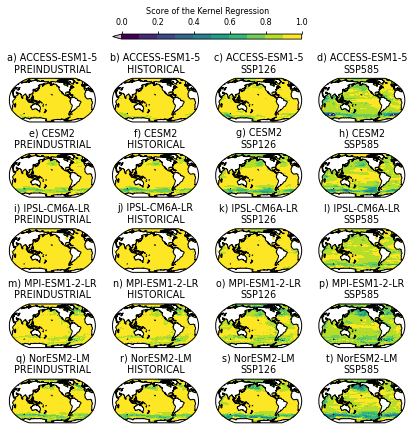

In [16]:
%%time
print(datetime.datetime.now())
print('Maps score KR: fig')

#-----------------
# Load data2plot
#-----------------

with open(data2plot_file, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+data2plot_file)       


#-----------------
# FIGURE PARAM
#-----------------

nrow = len(model_list)
ncol = len(simu_list)
fsize = (18*cm2in, 16*cm2in) # width height
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# CREATE CUSTOM CMAP
#-----------------

from matplotlib.colors import ListedColormap
from matplotlib import cm
cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors[:])
cmap.set_under(color='silver')
cmap.set_over(color='silver')
cmap.set_bad(color='silver', alpha=0)

#-----------------
# KEYWORDS DICT
#-----------------

kwmap = {'vmin':0, 'vmax':1, 'cmap':cmap, \
         'transform':ccrs.PlateCarree() }

#---------------------
# Plot score maps
#---------------------

irow = 0
for model in model_list: 
    icol = 0
    for simu in simu_list: 

        zax = ax[irow, icol]
        X = data2plot['maps'][model][simu]['X']
        Y = data2plot['maps'][model][simu]['Y']
        Z = data2plot['maps'][model][simu]['Z']
        pcm = zax.pcolormesh(X, Y, Z, **kwmap)    
        zax.set_title(subnum.pop()+') '+ model+'\n'+simu_name[simu].upper())
        zax.coastlines()
        # gl = zax.gridlines(crs=ccrs.PlateCarree(), linewidth=1)
        
        icol+=1

    #
    irow+=1
#
# fig.tight_layout()

#---------------------
# Repositionning axes
#---------------------

for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        ny0 = zw1.y0 - (irow+1)*0.1*zw1.height
        zax.set_position([zw1.x0, ny0, zw1.width, zw1.height])
    #
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 1].get_position()
zw2 = ax[0, 2].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .9*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='min')
cbar.set_label(r'Score of the Kernel Regression')

#---------------------
# Save figure
#---------------------

fignam = 'maps-score-KR.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# 23s

## Histogram and interquartile gathering all models for each scenario

2022-12-05 18:02:09.339549
Histogram and interquartile gathering all models for each scenario
CPU times: user 3.52 s, sys: 624 ms, total: 4.14 s
Wall time: 2.57 s


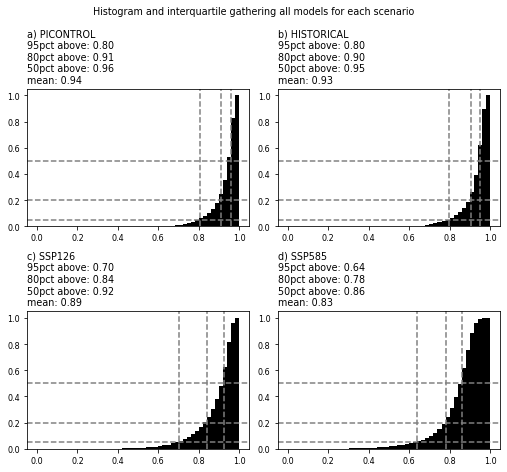

In [17]:
%%time
print(datetime.datetime.now())
print('Histogram and interquartile gathering all models for each scenario')

zfact = 1e6*3600*24 # kmol/m2/s -> mmol/m2/d

#-----------------
# FIGURE PARAM
#-----------------

nrow = 2
ncol = 2
fsize = (18*cm2in, 16*cm2in) # width height
fig, ax = plt.subplots(nrow, ncol, figsize=fsize,
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# KEYWORDS DICT
#-----------------

kwhist = dict(bins=50, range=[0, 1], cumulative=True, density=True, color='black')
kwlines = dict(color='gray', ls='--')

#---------------------
# Plot histograms
#---------------------

for isimu, simu in enumerate(simu_list): 

    zwdata = []
    for model in model_list: 
        zwdata.extend(data2plot['maps'][model][simu]['Z'].flatten())
    #
    zax = ax.flat[isimu]
    pcm = zax.hist(zwdata, **kwhist)    

    quantile50 = np.nanquantile(zwdata, .5)
    quantile20 = np.nanquantile(zwdata, .2)
    quantile05 = np.nanquantile(zwdata, .05)
    
    zax.axhline(0.05, **kwlines)
    zax.axhline(0.2, **kwlines)
    zax.axhline(0.5, **kwlines)
    zax.axvline(quantile50, **kwlines)
    zax.axvline(quantile20, **kwlines)
    zax.axvline(quantile05, **kwlines)
    zax.set_title(subnum.pop()+") "+simu.upper()+"\n95pct above: %.2f\n80pct above: %.2f\n50pct above: %.2f\nmean: %.2f" 
                  %(quantile05, quantile20, quantile50, np.nanmean(zwdata)), loc='left')

    
    #
#
fig.suptitle('Histogram and interquartile gathering all models for each scenario', y=1.03)
fig.tight_layout()

# Maps summarizing the score of KR

## Inputs

In [50]:
%%time
print(datetime.datetime.now())
print('Maps summarizing the score of KR: inputs')

data2plot_dir = dirroot + 'dimred-220602-score-analysis/'
grid  = '360x180'
data2plot_file = data2plot_dir+'data2plot-maps-summarize-score-KR-'+grid+'.pckl'

# model_list = ['NorESM2-LM', 'MPI-ESM1-2-LR', 'CNRM-ESM2-1', 'CESM2', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR']
model_list = ['ACCESS-ESM1-5', 'CESM2', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'NorESM2-LM']
simu_list  = ['picontrol', 'historical', 'ssp126', 'ssp585']
#grid_list  = ['90x45', '180x90']

simu_name = {
    'picontrol': 'preindustrial', 
    'historical': 'historical', 
    'ssp126': 'SSP126', 
    'ssp585': 'SSP585'
}


2022-12-05 19:05:20.274068
Maps summarizing the score of KR: inputs
CPU times: user 477 µs, sys: 73 µs, total: 550 µs
Wall time: 359 µs


## Fig

2022-12-05 20:27:53.324999
Maps summarizing the score of KR: fig
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/dimred-220602-score-analysis/data2plot-maps-summarize-score-KR-360x180.pckl
Figure saved: maps-summarize-score-KR.png
CPU times: user 10.9 s, sys: 1.73 s, total: 12.6 s
Wall time: 8.12 s


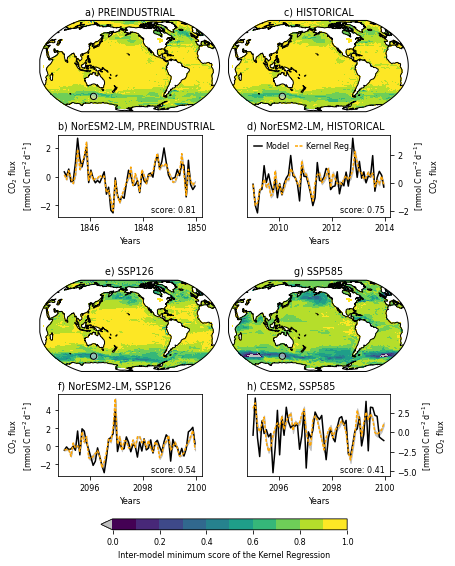

In [88]:
%%time
print(datetime.datetime.now())
print('Maps summarizing the score of KR: fig')

#-----------------
# Load data2plot
#-----------------

with open(data2plot_file, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+data2plot_file)       

zfact = 1e6*3600*24 # kmol/m2/s -> mmol/m2/d
gridpt_name = 'gridpt 1'

#-----------------
# FIGURE PARAM
#-----------------

nrow = 2
ncol = 2
fsize = (18*cm2in, 16*cm2in) # width height
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# CREATE CUSTOM CMAP
#-----------------

from matplotlib.colors import ListedColormap
from matplotlib import cm
cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors[:])
cmap.set_under(color='silver')
cmap.set_over(color='silver')
cmap.set_bad(color='silver', alpha=0)


#-----------------
# KEYWORDS DICT
#-----------------

#_________________
# Maps

kwmap = {'vmin':0, 'vmax':1, 'cmap':cmap, \
         'transform':ccrs.PlateCarree() }
# kwscatter = dict(edgecolor='k', facecolor='lightgray', alpha = .7, s=40, \
#                  transform=ccrs.PlateCarree())
kwscatter = dict(color='lightgray', alpha = .6, s=40, \
                 transform=ccrs.PlateCarree())
kwscatter2 = dict(edgecolor='k', facecolor='none', alpha = 1, s=40, \
                 transform=ccrs.PlateCarree())
# kwscatter = dict(marker='+', s=60, linewidths=3, \
#                  transform=ccrs.PlateCarree())

#_________________
# Time series

kwtruth = dict(ls='-' , label='Model'   , color='k')
kwkr    = dict(ls='--', dashes=[2, 1], label='Kernel Reg.'      , color='orange')
kwstd   = dict(label='$\pm$ std'        , color='silver')
kwref   = dict(ls='--', label='Trend + Seasonal cycle'    , color='royalblue')

kwbbox  = dict(boxstyle ="round", fc ="0.8")

#---------------------
# Plot score maps
#---------------------

for isimu, simu in enumerate(simu_list): 

    zax = ax.flat[isimu]
    X = data2plot['maps'][simu]['X']
    Y = data2plot['maps'][simu]['Y']
    Z = data2plot['maps'][simu]['min score']
    pcm = zax.pcolormesh(X, Y, Z, **kwmap)    
    zax.coastlines()
    # gl = zax.gridlines(crs=ccrs.PlateCarree(), linewidth=1)
    # zax.set_title(subnum.pop() + ') ' + simu.upper(), loc='left')

#

# fig.tight_layout()

#---------------------
# Repositionning axes
#---------------------

for icol, zax in enumerate(ax[1, :]): 
    zw1 = zax.get_position()
    ny0 = zw1.y0 - .8*zw1.height
    zax.set_position([zw1.x0, ny0, zw1.width, zw1.height])
#
for irow, zax in enumerate(ax[:, 1]): 
    zw1 = zax.get_position()
    nx0 = zw1.x0 - .15*zw1.width
    zax.set_position([nx0, zw1.y0, zw1.width, zw1.height])
#

#---------------------
# Plot score timeseries
#---------------------

axts = []
for isimu, simu in enumerate(simu_list): 

    zw1 = ax.flat[isimu].get_position()
    nx0 = zw1.x0+.1*zw1.width
    ny0 = zw1.y0 - 1.15*zw1.height
    nw  = .8*zw1.width
    nh  = .9*zw1.height
    zaxts = fig.add_axes([nx0, ny0, nw, nh]) 
    axts.append(zaxts)

    istart = -5*12    
    X      = data2plot['timeseries'][simu][gridpt_name]['time'] [istart:]  
    Yref   = zfact*data2plot['timeseries'][simu][gridpt_name]['Ref']  [istart:]  
    Ykr    = zfact*data2plot['timeseries'][simu][gridpt_name]['KR']   [istart:]  
    Ykrsup = zfact*data2plot['timeseries'][simu][gridpt_name]['KRsup'][istart:]   
    Ykrinf = zfact*data2plot['timeseries'][simu][gridpt_name]['KRinf'][istart:]  
    Ytruth = zfact*data2plot['timeseries'][simu][gridpt_name]['Truth'][istart:]  
    gridpt = data2plot['timeseries'][simu][gridpt_name]['gridpt']
        
    lltruth, = zaxts.plot(X, Ytruth-Yref, **kwtruth)
    #llref,   = zaxts.plot(X, Yref  , **kwref)
    llstd    = zaxts.fill_between(X, Ykrinf-Yref, Ykrsup-Yref, **kwstd)
    llkr,    = zaxts.plot(X, Ykr-Yref, **kwkr)

    zaxts.set_xlabel('Years')
    
    # compute pearson correlation
    zwYref   = zfact*data2plot['timeseries'][simu][gridpt_name]['Ref']  
    zwYkr    = zfact*data2plot['timeseries'][simu][gridpt_name]['KR']    - zwYref
    zwYtruth = zfact*data2plot['timeseries'][simu][gridpt_name]['Truth'] - zwYref
    zwpearsonr = pearsonr(zwYtruth, zwYkr)
    
    # add min score 
    zwminscore = data2plot['maps'][simu]['min score'][jj, ii]
    bbox = dict(boxstyle="round", fc="0.9")
    # zaxts.annotate('score: %.2f\ncorr: %.2f\npval:%.2f' %(zwminscore, zwpearsonr[0],  zwpearsonr[1]), (0.65, 0.05),xycoords='axes fraction')
    zaxts.annotate('score: %.2f' %(zwminscore), (0.65, 0.05),xycoords='axes fraction')
    
    # Add point on map
    jj, ii = gridpt[0], gridpt[1]
    X = data2plot['maps'][simu]['X']
    Y = data2plot['maps'][simu]['Y']
    ax.flat[isimu].scatter(X[jj, ii], Y[jj, ii], **kwscatter)
    ax.flat[isimu].scatter(X[jj, ii], Y[jj, ii], **kwscatter2)
    
#

axts = np.array(axts).reshape((2, 2))


#---------------------
# Set time series labels
#---------------------

for irow, zax in enumerate(axts[:, 1]): 
    zax.yaxis.set_ticks_position('right')
    zax.yaxis.set_label_position('right')
    zax.set_ylabel('[mmol$\,$C$\,$m$^{-2}\,$d$^{-1}$]\nCO$_2$ flux')
#
for irow, zax in enumerate(axts[:, 0]): 
    zax.set_ylabel('CO$_2$ flux\n[mmol$\,$C$\,$m$^{-2}\,$d$^{-1}$]')
#

for isimu, simu in enumerate(simu_list): 
    modelname = data2plot['timeseries'][simu][gridpt_name]['model name']
    zax = ax.flat[isimu]
    zaxts = axts.flat[isimu]
    zax.set_title(subnum.pop() + ') ' + simu_name[simu].upper())
    zaxts.set_title(subnum.pop() + ') %s, %s' %(modelname, simu_name[simu].upper()), loc='left')
#

#---------------------
# Set legend
#---------------------

# zw1 = axts[1, 0].get_position()
# zw2 = axts[1, 1].get_position()
# nx0 = zw1.x1
# nwidth = zw2.x0 - nx0
# nheight= 0.7*zw1.height
# ny0 = zw1.y0 - nheight
# axleg = fig.add_axes([nx0, ny0, nwidth, nheight])
# #axleg.legend(handles=[lltruth, llref, llkr], ncol=3, loc='lower center')
# axleg.legend(handles=[lltruth, llkr], ncol=2, loc='lower center')
# axleg.axis('off')

axts[0, 1].legend(handles=[lltruth, llkr], ncol=2, loc='upper left',
                  handlelength=1, columnspacing=.7, handletextpad=.4, 
                  frameon=False)

#---------------------
# Colorbar
#---------------------

# zw1 = ax[0, 0].get_position()
# zw2 = ax[0, 1].get_position()
# nx0 = zw1.x0 + 0.3*zw1.width
# ny0 = zw1.y1 + .5*zw1.height
# nw  = zw2.x1 - 0.3*zw2.width - nx0
# nh  = 0.05*nw
# cax = fig.add_axes([nx0, ny0, nw, nh])
# cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', \
#                     ticklocation='top', extend='min')
# cbar.set_label(r'Inter-model minimum score of the Kernel Regression')

zw1 = axts[1, 0].get_position()
zw2 = axts[1, 1].get_position()
nx0 = zw1.x0 + 0.3*zw1.width
ny0 = zw1.y0 - .65*zw1.height
nw  = zw2.x1 - 0.3*zw2.width - nx0
nh  = 0.05*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', \
                    ticklocation='bottom', extend='min')
cbar.set_label(r'Inter-model minimum score of the Kernel Regression')


#---------------------
# Save figure
#---------------------

fignam = 'maps-summarize-score-KR.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# 12s

## Histogram and interquartile of the inter-model min score

2022-12-05 17:58:22.602333
Histogram and interquartile of the inter-model min score
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/dimred-220602-score-analysis/data2plot-maps-summarize-score-KR-360x180.pckl
CPU times: user 2.99 s, sys: 653 ms, total: 3.64 s
Wall time: 1.89 s


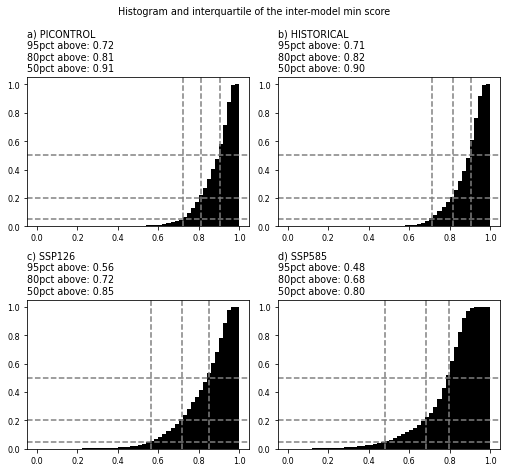

In [11]:
%%time
print(datetime.datetime.now())
print('Histogram and interquartile of the inter-model min score')

zfact = 1e6*3600*24 # kmol/m2/s -> mmol/m2/d

#-----------------
# Load data2plot
#-----------------

with open(data2plot_file, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+data2plot_file)       


#-----------------
# FIGURE PARAM
#-----------------

nrow = 2
ncol = 2
fsize = (18*cm2in, 16*cm2in) # width height
fig, ax = plt.subplots(nrow, ncol, figsize=fsize,
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# KEYWORDS DICT
#-----------------

kwhist = dict(bins=50, range=[0, 1], cumulative=True, density=True, color='black')
kwlines = dict(color='gray', ls='--')

#---------------------
# Plot histograms
#---------------------

for isimu, simu in enumerate(simu_list): 

    zax = ax.flat[isimu]
    zwdata = data2plot['maps'][simu]['min score'].flatten()
    pcm = zax.hist(zwdata, **kwhist)    
    quantile50 = np.nanquantile(zwdata, .5)
    quantile20 = np.nanquantile(zwdata, .2)
    quantile05 = np.nanquantile(zwdata, .05)
    zax.axhline(0.05, **kwlines)
    zax.axhline(0.2, **kwlines)
    zax.axhline(0.5, **kwlines)
    zax.axvline(quantile50, **kwlines)
    zax.axvline(quantile20, **kwlines)
    zax.axvline(quantile05, **kwlines)
    zax.set_title(subnum.pop()+") "+simu.upper()+"\n95pct above: %.2f\n80pct above: %.2f\n50pct above: %.2f" %(quantile05, quantile20, quantile50), loc='left')
#

fig.suptitle('Histogram and interquartile of the inter-model min score', y=1.03)

fig.tight_layout()

# ca. 3s

## Maps models with lowest score

2022-11-21 17:50:16.020120
Maps models with lowest score
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/dimred-220602-score-analysis/data2plot-maps-summarize-score-KR-360x180.pckl
Figure saved: maps-models-lowest-score-KR.png
CPU times: user 6.79 s, sys: 839 ms, total: 7.63 s
Wall time: 5.24 s


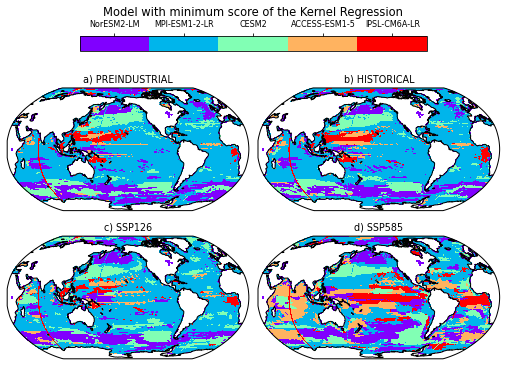

In [78]:
%%time
print(datetime.datetime.now())
print('Maps models with lowest score')

#-----------------
# Load data2plot
#-----------------

with open(data2plot_file, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+data2plot_file)       

zfact = 1e6*3600*24 # kmol/m2/s -> mmol/m2/d

#-----------------
# FIGURE PARAM
#-----------------

nrow = 2
ncol = 2
fsize = (18*cm2in, 16*cm2in) # width height
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# KEYWORDS DICT
#-----------------

#_________________
# Create new cmap

cmap = cm.get_cmap('rainbow', 256)
newcolors = cmap(np.linspace(0, 1, 5))
cmap = ListedColormap(newcolors[:])
cmap.set_under(color='silver')
cmap.set_over(color='silver')
cmap.set_bad(color='silver', alpha=0)

kwmap = {'vmin':-.5, 'vmax':4.5, 'cmap':cmap, \
         'transform':ccrs.PlateCarree() }


#---------------------
# Plot score maps
#---------------------

for isimu, simu in enumerate(simu_list): 

    zax = ax.flat[isimu]
    X = data2plot['maps'][simu]['X']
    Y = data2plot['maps'][simu]['Y']
    Z = data2plot['maps'][simu]['worse model']
    pcm = zax.pcolormesh(X, Y, Z, **kwmap)    
    zax.coastlines()
    # gl = zax.gridlines(crs=ccrs.PlateCarree(), linewidth=1)
    zax.set_title(subnum.pop() + ') ' + simu_name[simu].upper())

#

fig.tight_layout()

#---------------------
# Repositionning axes
#---------------------

for icol, zax in enumerate(ax[1, :]): 
    zw1 = zax.get_position()
    ny0 = zw1.y0 + .4*zw1.height
    zax.set_position([zw1.x0, ny0, zw1.width, zw1.height])
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 0].get_position()
zw2 = ax[0, 1].get_position()
nx0 = zw1.x0 + 0.3*zw1.width
ny0 = zw1.y1 + .3*zw1.height
nw  = zw2.x1 - 0.3*zw2.width - nx0
nh  = 0.05*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='neither', ticks=np.arange(0,5))
cbar.ax.set_xticklabels(data2plot['maps']['picontrol']['model list ordered'])  
cbar.set_label(r'Model with minimum score of the Kernel Regression', size='x-large')


#---------------------
# Save figure
#---------------------

fignam = 'maps-models-lowest-score-KR.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# 12s

# Maps clusters
Inspired by the code in dimred-220826-cluster-analysis.ipynb
Reorganize clusters with decreasing fiALK/fiDIC ratio + stippling for area with sum of fiALK and fiDIC lower than 0.6

## Input

In [40]:
data2plot_dir = dirroot + 'BIOME/V6/'

model_list = ['ACCESS-ESM1-5', 'CESM2', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'NorESM2-LM']
simu_list  = ['picontrol', 'historical', 'ssp126', 'ssp585']
feature_list = ['siconc', 'talk', 'dissic', 'tos', 'sfcWind', 'sos', 'po4', 'atmco2']
nboldclusters = 10
grid = '360x180'


## Clusters grouping and naming

In [41]:
%%time
print(datetime.datetime.now())
print('Maps clusters: clusters grouping and naming')


# group 1: sea ice
# group 2: DIC/ALK (nb: this relate to the buffer factor Samiento and Gruber, 2006, p. 333)
# group 3: Specific cluster
clusters_old_groups_dicts = {
    'NorESM2-LM': {
        'group 1': [10], 
        'group 2': [1, 2, 3, 4, 5, 6, 7, 8, 9]
    }, 
    'MPI-ESM1-2-LR': {
        'group 1': [10], 
        'group 2': [1, 2, 3, 4, 5, 6, 7, 8, 9]
    }, 
    'CESM2': {
        'group 1': [10], 
        'group 2': [1, 2, 3, 4, 5, 6, 7, 8, 9]
    }, 
    'ACCESS-ESM1-5': {
        'group 1': [10], 
        'group 2': [1, 2, 3, 4, 5, 6, 7, 8, 9]
    }, 
    'IPSL-CM6A-LR': {
        'group 1': [10], 
        'group 2': [1, 2, 3, 4, 5, 6, 7, 8, 9]
    }    
}

#-----------------
# CREATE CUSTOM CMAP
#-----------------

cmap_dict = {}
for kkk in clusters_old_groups_dicts.keys(): 
    zw = [cm.get_cmap('cool'    , 256)(np.linspace(0.1, 0.3, len(clusters_old_groups_dicts[kkk]['group 1']) )), 
          cm.get_cmap('plasma_r', 256)(np.linspace(0, .7, len(clusters_old_groups_dicts[kkk]['group 2'])))]
    newcolors=np.concatenate(zw)
    cmap = ListedColormap(newcolors)

    cmap.set_under(color='silver')
    cmap.set_over(color='silver')
    cmap.set_bad(color='silver', alpha=0)
    
    cmap_dict[kkk] = cmap
#
       

2022-11-21 17:15:18.275731
Maps clusters: clusters grouping and naming
CPU times: user 7.85 ms, sys: 2.1 ms, total: 9.95 ms
Wall time: 7.52 ms


## Define some functions

In [42]:
def read_biome_datas(zwfname, zwresolution): 

    if   zwresolution == 1: zwgridshape = (360, 180)
    elif zwresolution == 2: zwgridshape = (180, 90)
    elif zwresolution == 4: zwgridshape = (90, 45)
    else: exit('zwresolution not correct')

    zwdata = np.loadtxt(zwfname, dtype=str)
    # zwdata = np.genfromtxt(zwfname, dtype=str)
    Z = np.array(np.where(zwdata.flatten()=='NA', np.nan, zwdata.flatten()).reshape(zwgridshape), dtype=float).T
        
    # X and Y are adapted for plt.pcolormesh with shading='flat'
    zwX = np.arange(-180, 180+zwresolution/2., zwresolution)
    zwY = np.arange(-90, 90+zwresolution/2., zwresolution)
    X, Y = np.meshgrid(zwX, zwY)
    
    return Z, Y, X

#

## Load and prepare data2plot

In [43]:
%%time
print(datetime.datetime.now())
print('Maps clusters: load and prepare data2plot')

if   grid == '360x180': resolution = 1
elif grid == '180x90' : resolution = 2
elif grid == '90x45'  : resolution = 4
else: exit('grid not correct')

###################
# Load clusters
###################

clusters_old = {}

for model in model_list: 

    clusters_old[model] = {}
    
    for simu in simu_list: 
    
        fname_cluster = glob.glob(data2plot_dir + 'RPART9/' + model + '_' + simu + \
                                  '_grid' + grid + '_K_*_BIOME_RPART_9_opt_3D_SI.txt')[0]
        clusters_old[model][simu] = {'X': read_biome_datas(fname_cluster, resolution)[2], 
                                     'Y': read_biome_datas(fname_cluster, resolution)[1], 
                                     'Z': read_biome_datas(fname_cluster, resolution)[0]}
                                 
        print("File loaded: "+fname_cluster)

    #
#

###################
# Old clusters composition
###################

print('> Old clusters composition')

clusters_old_composition = {}

for model in model_list: 
    
    feature_importances = {}                
    
    #------------------
    # Read feature importances
    #------------------
    
    for simu in simu_list: 
        fname_fi = dirshared + 'fi-std-' + model + '-' + simu + '-' + grid + '.pckl'
        with open(fname_fi, 'rb') as f1: feature_importances[simu] = pickle.load(f1)
        print("File loaded: "+fname_fi)
    #
    
    #------------------
    # Compute cluster compositions
    #------------------
    
    clusters_old_composition[model] = {}
        
    for feature in feature_list: 

        clusters_old_composition[model][feature] = {'avg':[], 'std':[]}

        for cluster_num in np.arange(1, nboldclusters+.5): 
            zw= []
            for simu in simu_list:         
                zwfeat_avg = feature_importances[simu][feature]['avg'].T
                zw.extend(zwfeat_avg[np.where( clusters_old[model][simu]['Z']==cluster_num )])        
            #
            clusters_old_composition[model][feature]['avg'].append(np.nanmean(zw))
            clusters_old_composition[model][feature]['std'].append(np.nanstd (zw))
        #
    #
#

###################
###################
###################
# Organizing new clusters in groups
# group 1: sea ice importance decreasing
# group 2: ratio DIC importance to ALK importance decreasing
###################
###################
###################

print('> Organizing new clusters in groups')

clusters_new1_groups_dicts = {}
for model in model_list: 

    clusters_new1_groups_dicts[model] = {}
    
    # group 1
    zwclusters = clusters_old_groups_dicts[model]['group 1']
    zwsiconc = clusters_old_composition[model]['siconc']['avg']
    # remove 1e20 from the index list
    zwidx = np.array(np.array(zwclusters)[np.array(zwclusters)<1e20], dtype=int) 
    # select zwsiconc indexes
    zwsiconc2 = []
    for iii in zwidx: zwsiconc2.append(zwsiconc[iii-1])
    # sort
    zwidx_sorted=[iii for _,iii in sorted(zip(zwsiconc2,zwidx))][::-1]
    # save
    clusters_new1_groups_dicts[model]['group 1'] = zwidx_sorted
    
    # group 2
    zwclusters = clusters_old_groups_dicts[model]['group 2']
    zwdic = clusters_old_composition[model]['dissic']['avg']
    zwalk = clusters_old_composition[model]['talk']['avg']
    # compute dic / alk
    zwrat=[]
    for iii in np.arange(len(zwdic)): zwrat.append(zwdic[iii]/zwalk[iii])
    # remove 1e20 from the index list
    zwidx = np.array(np.array(zwclusters)[np.array(zwclusters)<1e20], dtype=int)
    # select zwrat indexes
    zwrat2 = []
    for iii in zwidx: zwrat2.append(zwrat[iii-1])
    # sort
    zwidx_sorted=[iii for _,iii in sorted(zip(zwrat2,zwidx))]
    # save
    clusters_new1_groups_dicts[model]['group 2'] = zwidx_sorted

#
    

###################
# Create new to old clusters num dicts and vice versa
###################

print('> Create new1 to old clusters num dicts')

clusters_new1_to_old_dicts      = {}
for key1, item1 in clusters_new1_groups_dicts.items():     
    clusters_new1_to_old_dicts[key1] = {}
    icnt = 1
    for key2, item2 in item1.items(): 
        for ccc in item2: 
            clusters_new1_to_old_dicts[key1][str(icnt)]=ccc
            icnt+=1
        #
    #
#
  
clusters_old_to_new1_dicts = {}
for key1, value1 in clusters_new1_to_old_dicts.items(): 
    clusters_old_to_new1_dicts[key1] = {}
    for key2, value2 in value1.items(): 
        clusters_old_to_new1_dicts[key1][str(value2)] = int(key2)
    #
#
    
nbnew1clusters_dict = {}
for model in model_list: nbnew1clusters_dict[model] = len(clusters_new1_to_old_dicts[model].keys())


###################
# New clusters 
###################

print('> New clusters')

clusters_new1 = {}

for model in model_list: 

    clusters_new1[model] = {}
    
    for simu in simu_list: 

        clusters_new1[model][simu] = {}

        #--------------------
        # load X, Y, Z and dict
        #--------------------

        zwX = clusters_old[model][simu]['X']
        zwY = clusters_old[model][simu]['Y']    
        zwZ = clusters_old[model][simu]['Z']
        land = np.isnan(zwZ)

        zw_new_to_old = clusters_new1_to_old_dicts[model]

        #--------------------
        # Compute new clusters
        #--------------------

        nwZ = np.zeros_like(zwZ)
        for zwnew, zwold in zw_new_to_old.items(): 
            nwZ = np.where(zwZ == zwold, np.float(zwnew), nwZ)
        #
        nwZ[land]=np.nan    

        #--------------------
        # Save
        #--------------------
    
        clusters_new1[model][simu]['X'] = zwX
        clusters_new1[model][simu]['Y'] = zwY
        clusters_new1[model][simu]['Z'] = nwZ
       
    #
#
    
###################
# New clusters composition
###################

print('> New clusters composition')

clusters_new1_composition = {}

for model in model_list: 
    
    feature_importances = {}                
    clusters_new1_composition[model] = {}                
    
    #------------------
    # Read feature importances
    #------------------
    
    for simu in simu_list: 
        fname_fi = dirshared + 'fi-std-' + model + '-' + simu + '-' + grid + '.pckl'
        with open(fname_fi, 'rb') as f1: feature_importances[simu] = pickle.load(f1)
        print("File loaded: "+fname_fi)
    #
    
    #------------------
    # Compute cluster compositions
    #------------------
    
    clusters_new1_composition[model] = {}
        
    for feature in feature_list: 

        clusters_new1_composition[model][feature] = {'avg':[], 'std':[]}

        for cluster_num in np.arange(1, nbnew1clusters_dict[model]+.5): 
            zw= []
            for simu in simu_list:         
                zwfeat_avg = feature_importances[simu][feature]['avg'].T
                zw.extend(zwfeat_avg[np.where( clusters_new1[model][simu]['Z']==cluster_num )])        
            #
            clusters_new1_composition[model][feature]['avg'].append(np.nanmean(zw))
            clusters_new1_composition[model][feature]['std'].append(np.nanstd (zw))
        #
    #
#

###################
# New clusters ocean area
###################

print("> New clusters ocean area")
clusters_new1_ocean_area      = {}
earthradius = 6371 # km

for model in model_list: 

    clusters_new1_ocean_area[model] = {}

    for simu in simu_list: 

        clusters_new1_ocean_area[model][simu] = []
        
        zwX = clusters_new1[model][simu]['X']
        zwY = clusters_new1[model][simu]['Y']
        zwZ = clusters_new1[model][simu]['Z']
        zwcellarea = (np.sin( np.deg2rad(zwY[1:, :-1]) ) - np.sin(np.deg2rad(zwY[:-1, :-1]))) * \
        (np.deg2rad(zwX[:-1, 1:]) - np.deg2rad(zwX[:-1, :-1])) * earthradius**2
        
        totoceanarea = np.nansum( np.where(np.isfinite(zwZ), zwcellarea, np.nan) )

        for cluster_num in np.arange(1, nbnew1clusters_dict[model]+.5): 
            clusters_new1_ocean_area[model][simu].append( np.nansum( np.where(zwZ == cluster_num, zwcellarea, np.nan) ) / totoceanarea)
        #
    #
#


###################
###################
###################
# Organizing new clusters in groups
# and Create new to old clusters num dicts
# group 1: 0
# group 2: 1 for cluster with  sum of DIC and ALK importance below treshold
###################
###################
###################


treshold = 0.6

print('> Organizing new clusters in groups and create new to old clusters dicts')

clusters_new2_to_old_dicts      = {}

for model in model_list: 

    clusters_new2_to_old_dicts[model] = {'0':[], '1':[]}
    
    # group 1
    clusters_new2_to_old_dicts[model]['0'].extend( clusters_old_groups_dicts[model]['group 1'] )
    
    # group 2
    zwclusters = clusters_old_groups_dicts[model]['group 2']
    zwdic = clusters_old_composition[model]['dissic']['avg']
    zwalk = clusters_old_composition[model]['talk']['avg']
    # compute dic + alk
    zwsum=[]
    for iii in np.arange(len(zwdic)): zwsum.append(zwdic[iii] + zwalk[iii])
    # remove 1e20 from the index list and select clusters iidx
    zwidx = np.array(np.array(zwclusters)[np.array(zwclusters)<1e20], dtype=int)
    # sort clusters
    for iii in zwidx: 
        if zwsum[iii-1] <= treshold: clusters_new2_to_old_dicts[model]['1'].append(iii)
        elif zwsum[iii-1] > treshold: clusters_new2_to_old_dicts[model]['0'].append(iii)
        else: exit('something weird ini zwsum')
    #

#
   
nbnew2clusters_dict = {}
for model in model_list: nbnew2clusters_dict[model] = len(clusters_new2_to_old_dicts[model].keys())

###################
# Create new2 to new1 clusters num dicts
###################

clusters_new2_to_new1_dicts = {}

for kmodelname, vclusters_new2_to_old in clusters_new2_to_old_dicts.items(): 
    clusters_new2_to_new1_dicts[kmodelname] = {}
    for knew2, vold in vclusters_new2_to_old.items(): 
        clusters_new2_to_new1_dicts[kmodelname][knew2] = []
        for zwold in vold: 
            clusters_new2_to_new1_dicts[kmodelname][knew2].append(clusters_old_to_new1_dicts[kmodelname][str(zwold)])
        #
    #
#


###################
# New clusters 
###################

print('> New clusters')

clusters_new2 = {}

for model in model_list: 

    clusters_new2[model] = {}
    
    for simu in simu_list: 

        clusters_new2[model][simu] = {}

        #--------------------
        # load X, Y, Z and dict
        #--------------------

        zwX = clusters_old[model][simu]['X']
        zwY = clusters_old[model][simu]['Y']    
        zwZ = clusters_old[model][simu]['Z']
        land = np.isnan(zwZ)

        zw_new_to_old = clusters_new2_to_old_dicts[model]

        #--------------------
        # Compute new clusters
        #--------------------

        nwZ = np.zeros_like(zwZ)
        for zwnew, zwold_list in zw_new_to_old.items(): 
            for zwold in zwold_list: 
                nwZ = np.where(zwZ == zwold, np.float(zwnew), nwZ)
            #
        #
        nwZ[land]=np.nan    

        #--------------------
        # Save
        #--------------------
    
        clusters_new2[model][simu]['X'] = .5*(zwX[:, 1:]+zwX[:, :-1])[:-1, :]
        clusters_new2[model][simu]['Y'] = .5*(zwY[1:, :]+zwY[:-1, :])[:, :-1]
        clusters_new2[model][simu]['Z'] = nwZ


    #
#



# ca.  8s

2022-11-21 17:15:31.384919
Maps clusters: load and prepare data2plot
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/BIOME/V6/RPART9/ACCESS-ESM1-5_picontrol_grid360x180_K_80_BIOME_RPART_9_opt_3D_SI.txt
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/BIOME/V6/RPART9/ACCESS-ESM1-5_historical_grid360x180_K_80_BIOME_RPART_9_opt_3D_SI.txt
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/BIOME/V6/RPART9/ACCESS-ESM1-5_ssp126_grid360x180_K_80_BIOME_RPART_9_opt_3D_SI.txt
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/BIOME/V6/RPART9/ACCESS-ESM1-5_ssp585_grid360x180_K_80_BIOME_RPART_9_opt_3D_SI.txt
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/BIOME/V6/RPART9/CESM2_picontrol_grid360x180_K_105_BIOME_RPART_9_opt_3D_SI.txt
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/BIOME/V6/RPART9/CESM2_historical_grid360x180_K_105_BIOME_RPART_9_opt_3D_SI.txt
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NO

## Plot

2022-11-21 17:21:36.278445
Maps clusters: plot
Figure saved: maps-clusters.png
CPU times: user 57.1 s, sys: 5.3 s, total: 1min 2s
Wall time: 48.2 s


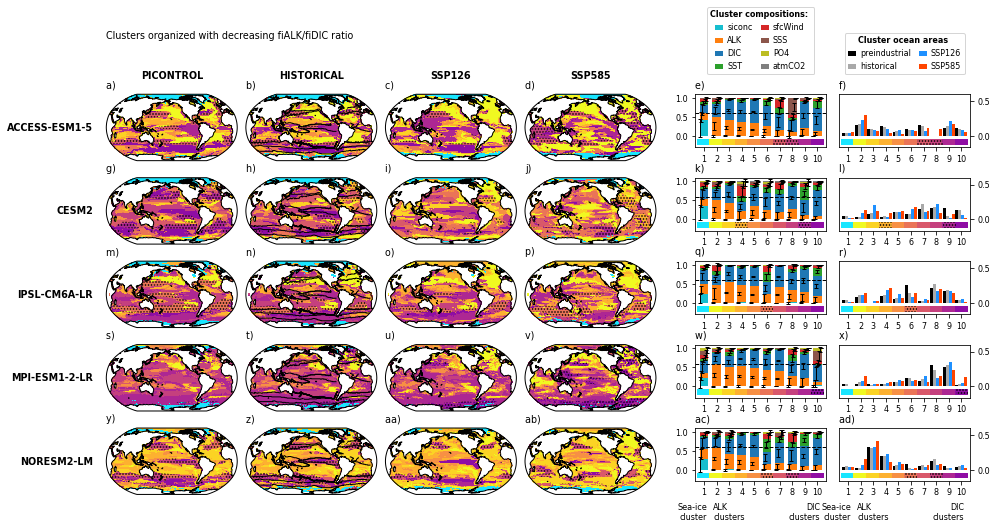

In [45]:
%%time
print(datetime.datetime.now())
print('Maps clusters: plot')

#-----------------
# FIGURE PARAM
#-----------------

nrow = len(model_list)
ncol = len(simu_list)
fsize = (20*cm2in, 18*cm2in) # width height
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()


biomes_fay_file='/mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/BIOME/Time_Varying_Biomes.nc'
zwds = xr.open_dataset(biomes_fay_file)
biomes_fay = {'X': zwds['MeanBiomes'].T['lon'].values, 
              'Y': zwds['MeanBiomes'].T['lat'].values, 
              'Z': zwds['MeanBiomes'].T.values}
nbiomes_fay = np.nanmax(biomes_fay['Z'])

##################
##################
#
# MAPS
#
##################
##################

    
#---------------------
# Plot
#---------------------

irow = 0
pcm = np.zeros_like(ax)
for model in model_list: 
    icol = 0
    kwmap = dict(cmap=cmap_dict[model], vmin=.5, \
                 vmax=nbnew1clusters_dict[model]+.5, \
                 transform=ccrs.PlateCarree() )

    dens = 4
    kwmap2 = dict(transform=ccrs.PlateCarree(), colors='none', hatches=[dens*'.', dens*'.'])

    for simu in simu_list: 

        zax = ax[irow, icol]
        X = clusters_new1[model][simu]['X']
        Y = clusters_new1[model][simu]['Y']
        Z = clusters_new1[model][simu]['Z']
        
        zwpcm = zax.pcolormesh(X, Y, Z, **kwmap)
        
        if simu == 'historical': 
            zax.contour(biomes_fay['X'], biomes_fay['Y'], biomes_fay['Z'], \
                        levels=np.arange(1, nbiomes_fay+.5), colors='k', \
                        transform=ccrs.PlateCarree(), linewidths=1.)
        
        X2 = clusters_new2[model][simu]['X']
        Y2 = clusters_new2[model][simu]['Y']
        Z2 = clusters_new2[model][simu]['Z']
        zax.contourf(X2, Y2, Z2, levels = [0.5, 1.5], **kwmap2)
        zax.set_global()

        #zax.set_title('%s, %s' %(model.upper(), simu.upper()))
        zax.coastlines()
        # gl = zax.gridlines(crs=ccrs.PlateCarree(), linewidth=1)
        pcm[irow, icol] = zwpcm
        icol+=1

    #
    irow+=1
#

fig.tight_layout()

#---------------------
# Move axis
#---------------------

dy = .2*ax[0, 0].get_position().height
for iaxrow, axrow in enumerate(ax[1:]): 
    for zax in axrow: 
        
        zw = zax.get_position()
        ny0 = zw.y0 + (iaxrow+1)*dy
        zax.set_position([zw.x0, ny0, zw.width, zw.height])
    #
#

##################
##################
#
# CLUSTER BARPLOT
#
##################
##################

#-----------------
# KEYWORDS DICT
#-----------------

nbfeature = len(feature_list)
www = 1/(nbfeature+3)
kwbar = dict(align='edge', width=www)

featurecolors = {
    'siconc' :'tab:cyan', 
    'talk'   :'tab:orange',
    'dissic' :'tab:blue', 
    'tos'    :'tab:green', 
    'sfcWind':'tab:red', 
    'sos'    :'tab:brown', 
    'po4'    :'tab:olive', 
    'atmco2' :'tab:gray'
}
simucolors = {
    'picontrol':'black', 
    'historical':'darkgray',
    'ssp126':'dodgerblue', 
    'ssp585':'orangered'
}

feature_name = {
    'siconc' :'siconc', 
    'talk'   :'ALK',
    'dissic' :'DIC', 
    'tos'    :'SST', 
    'sfcWind':'sfcWind', 
    'sos'    :'SSS', 
    'po4'    :'PO4', 
    'atmco2' :'atmCO2'    
}
simu_name = {
    'picontrol': 'preindustrial', 
    'historical': 'historical', 
    'ssp126': 'SSP126', 
    'ssp585': 'SSP585'
}

#---------------------
# Plot
#---------------------
axbarplot1 = []
axbarplot2 = []
cbar = []
for imodel, model in enumerate(model_list): 
    
    #_________________
    # relative importances

    zw = ax[imodel, -1].get_position()
    nx0 = zw.x1 + 0.3*zw.width
    ny0 = zw.y0+0.2*zw.height
    nh = 0.8*zw.height
    nw = zw.width
    zax1 = fig.add_axes([nx0, ny0, nw, nh])
    axbarplot1.append(zax1)
    
    www=0.7
    xxx=np.arange(1, nbnew1clusters_dict[model]+1)
    www1=www/nbfeature
    xxx1=xxx-0.35+www1/2.
    bbb=np.zeros_like(xxx)
    for feature in feature_list: 
        hhh = clusters_new1_composition[model][feature]['avg']
        hhh = np.where(np.isnan(hhh), 0, hhh)
        zax1.bar(xxx, hhh, bottom=bbb, label=feature_name[feature], 
                #yerr=cluster_composition[model][feature]['std'], 
                width=www, align='center', color=featurecolors[feature])
        zax1.errorbar(xxx1, bbb+np.array(hhh)/2, 
                      yerr=clusters_new1_composition[model][feature]['std'],
                      fmt='none', ecolor='k', elinewidth=1., capsize=2)
        xxx1=xxx1+www1
        bbb = bbb+hhh
    #
    
    hdls1 = zax1.get_legend_handles_labels()   
    
    #_________________
    # add colorbar relative importances

    zpcm = pcm[imodel, 0]
    zw = zax1.get_position()
    nx0 = zw.x0 + .015*zw.width
    nw = zw.x1 - .015*zw.width - nx0
    ny0 = zw.y0 + .05*zw.height
    nh  = .05 * nw
    zwcax = fig.add_axes([nx0, ny0, nw, nh])
    zwcbar = plt.colorbar(zpcm, cax=zwcax, orientation='horizontal', \
                        extend='neither', \
                        ticks=[])
    cbar.append(zwcbar)
    
    #_________________
    # add stippling on colorbar relative importances

    zw = zwcax.get_position()
    ny0 = zw.y0
    nh = zw.height
    for zwcluster in clusters_new2_to_new1_dicts[model]['1']: 
        nw = 1/nbnew1clusters_dict[model] * zw.width
        nx0 = zw.x0 + (zwcluster-1)*nw
        zaxstippling=fig.add_axes([nx0, ny0, nw, nh])
        ppp=mpl.patches.Rectangle((0, 0), 1, 1, hatch=dens*'.', fill=False, lw=0)
        zaxstippling.add_patch(ppp)
        zaxstippling.set_axis_off()
    #
    
    #_________________
    # set x and y axis relative importances

    xtickname = []
    zax1.set_xticks(xxx)
    # if imodel==len(model_list)-1: 
    #     for iii in xxx: xtickname.append('cluster '+str(iii))
    #     zax1.set_xticklabels(xtickname, rotation=40, horizontalalignment='right')
    # else: zax1.set_xticklabels('')
    for iii in xxx: xtickname.append(str(iii))
    zax1.set_xticklabels(xtickname)
    zax1.set_ylim((-.3, 1.1))
    zax1.set_xlim((xxx[0]-www, xxx[-1]+www))
    #zax1.set_title(model.upper()+', relative importances')
    zax1.axhline(treshold, lw=1, c='k', ls='--')

    #_________________
    # Ocean areas
    
    zw = zax1.get_position()
    nx0 = zw.x1 + 0.1*zw.width
    ny0 = zw.y0
    nh = zw.height
    nw = zw.width
    zax2 = fig.add_axes([nx0, ny0, nw, nh])
    axbarplot2.append(zax2)

    xxx=np.arange(1, nbnew1clusters_dict[model]+1)
    www=0.7/3
    for simu in simu_list: 
        zax2.bar(xxx, clusters_new1_ocean_area[model][simu], label=simu_name[simu],
                width=www, align='edge', color=simucolors[simu])
        xxx=xxx+www
    #
    zax2.yaxis.tick_right()

    hdls2 = zax2.get_legend_handles_labels()   
    
    #_________________
    # add colorbar Ocean areas

    zpcm = pcm[imodel, 0]
    zw = zax2.get_position()
    nx0 = zw.x0 + .015*zw.width
    nw = zw.x1 - .015*zw.width - nx0
    ny0 = zw.y0 + .05*zw.height
    nh  = .05 * nw
    zwcax = fig.add_axes([nx0, ny0, nw, nh])
    zwcbar = plt.colorbar(zpcm, cax=zwcax, orientation='horizontal', \
                        extend='neither', \
                        ticks=[])
    cbar.append(zwcbar)
    
    #_________________
    # add stippling on colorbar Ocean areas

    zw = zwcax.get_position()
    ny0 = zw.y0
    nh = zw.height
    for zwcluster in clusters_new2_to_new1_dicts[model]['1']: 
        nw = 1/nbnew1clusters_dict[model] * zw.width
        nx0 = zw.x0 + (zwcluster-1)*nw
        zaxstippling=fig.add_axes([nx0, ny0, nw, nh])
        ppp=mpl.patches.Rectangle((0, 0), 1, 1, hatch=dens*'.', fill=False, lw=0)
        zaxstippling.add_patch(ppp)
        zaxstippling.set_axis_off()
    #
    
    #_________________
    # set x and y axis Ocean areas

    xxx0 = np.arange(1, nbnew1clusters_dict[model]+1)
    xtickpos = .5*(xxx-xxx0)+xxx0
    xtickname = []
    num=0
    zax2.set_xticks(xtickpos)
    # if imodel==len(model_list)-1: 
    #     for iii in xtickpos: 
    #         xtickname.append('cluster '+str(num+1))
    #         num+=1
    #     #
    #     zax2.set_xticklabels(xtickname, rotation = 40, horizontalalignment='right')
    # else: zax2.set_xticklabels('')
    for iii in xtickpos: 
        xtickname.append(str(num+1))
        num+=1
    #
    zax2.set_xticklabels(xtickname)
    zax2.set_ylim((-.164, .6))
    zax2.set_xlim((xtickpos[0]-3*www, xtickpos[-1]+3*www))
    #zax2.set_title(model.upper()+', ocean areas')
    

#

# remove cbar borders
for zwcbar in cbar: zwcbar.outline.set_visible(False)

#---------------------
# Add numbering to titles of subplots
#---------------------

for irow, axrow in enumerate(ax): 
    for zax in axrow: 
        zwtitle = subnum.pop() + ') ' + zax.get_title()
        zax.set_title(zwtitle, loc='left')
    #
    zwtitle = subnum.pop() + ') '+ axbarplot1[irow].get_title()
    axbarplot1[irow].set_title(zwtitle, loc='left')
    zwtitle = subnum.pop() + ') '+ axbarplot2[irow].get_title()
    axbarplot2[irow].set_title(zwtitle, loc='left')
#

#---------------------
# Add legends
#---------------------

kwleg = dict(handlelength=1, handleheight=.7, handletextpad=.5, columnspacing=1., \
             loc='lower center')

zw = axbarplot1[0].get_position()
nx0 = zw.x1 - 0.5*zw.width
ny0 = zw.y1+0.3*zw.height
zax = fig.add_axes([nx0, ny0, 0, 0])
zax.axis('off')
leg=zax.legend(handles=hdls1[0], labels=hdls1[1], ncol=2, **kwleg)
leg.set_title('Cluster compositions: ', prop=dict(weight='bold'))

zw = axbarplot2[0].get_position()
nx0 = zw.x1 - 0.5*zw.width
ny0 = zw.y1+0.3*zw.height
zax = fig.add_axes([nx0, ny0, 0, 0])
zax.axis('off')
leg=zax.legend(handles=hdls2[0], labels=hdls2[1], ncol=2, **kwleg)
leg.set_title('Cluster ocean areas ', prop=dict(weight='bold'))

#---------------------
# Add text to describe cluster
#---------------------

zw = axbarplot1[-1].get_position()
ny0 = zw.y0 - .4*zw.height
nx0 = zw.x0 + 1/11.*zw.width
fig.text(nx0, ny0, 'Sea-ice\ncluster', ha='right', va='top')
nx0 = zw.x0 + 1.5/11.*zw.width
fig.text(nx0, ny0, 'ALK\nclusters', ha='left', va='top')
nx0 = zw.x0 + 10.5/11*zw.width
fig.text(nx0, ny0, 'DIC\nclusters', ha='right', va='top')

zw = axbarplot2[-1].get_position()
ny0 = zw.y0 - .4*zw.height
nx0 = zw.x0 + 1/11.*zw.width
fig.text(nx0, ny0, 'Sea-ice\ncluster', ha='right', va='top')
nx0 = zw.x0 + 1.5/11.*zw.width
fig.text(nx0, ny0, 'ALK\nclusters', ha='left', va='top')
nx0 = zw.x0 + 10.5/11*zw.width
fig.text(nx0, ny0, 'DIC\nclusters', ha='right', va='top')

#---------------------
# Add suptitle
#---------------------

zw = ax[0, 0].get_position()
nx0 = zw.x0
ny0 = zw.y1+0.8*zw.height
fig.suptitle('Clusters organized with decreasing fiALK/fiDIC ratio', y=ny0, x=nx0, \
             size='large', ha='left', va='bottom')

#---------------------
# Add text on the left: model names
#---------------------

kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='right', va='center')
for imodel, vmodel in enumerate(model_list): 
    zw1 = ax[imodel, 0].get_position()
    ny0 = 0.5 *(zw1.y0+zw1.y1)
    nx0 = zw1.x0 - .1*zw1.width
    fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
#

#---------------------
# Add text on the top: simu names
#---------------------

kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='center', va='bottom')
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[0, isimu].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .2*zw1.height
    fig.text(nx0, ny0, vsimu.upper(), **kwtxt)
#

#---------------------
# Save figure
#---------------------

fignam = 'maps-clusters.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# ca. 50s

## Plot summary

2022-11-21 14:06:58.385196
Maps clusters: plot summary
Figure saved: maps-clusters-summary.png
CPU times: user 40.7 s, sys: 3.73 s, total: 44.5 s
Wall time: 34.4 s


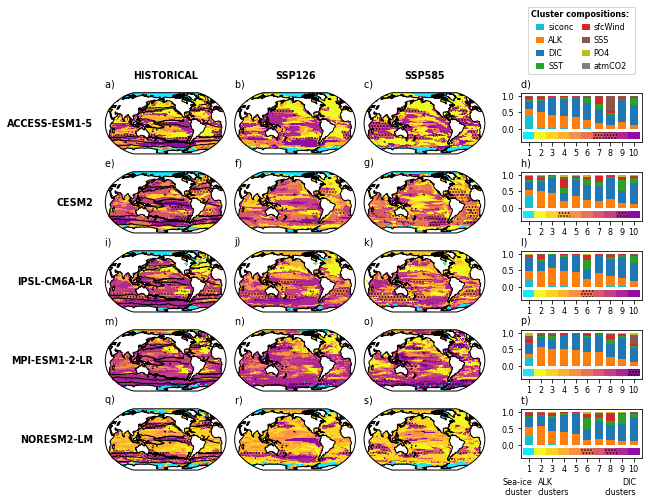

In [33]:
%%time
print(datetime.datetime.now())
print('Maps clusters: plot summary')

model_list = ['ACCESS-ESM1-5', 'CESM2', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'NorESM2-LM']
simu_list  = ['historical', 'ssp126', 'ssp585']

#-----------------
# FIGURE PARAM
#-----------------

nrow = len(model_list)
ncol = len(simu_list)
fsize = (14*cm2in, 17*cm2in) # width height
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()


biomes_fay_file='/mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/BIOME/Time_Varying_Biomes.nc'
zwds = xr.open_dataset(biomes_fay_file)
biomes_fay = {'X': zwds['MeanBiomes'].T['lon'].values, 
              'Y': zwds['MeanBiomes'].T['lat'].values, 
              'Z': zwds['MeanBiomes'].T.values}
nbiomes_fay = np.nanmax(biomes_fay['Z'])

##################
##################
#
# MAPS
#
##################
##################

    
#---------------------
# Plot
#---------------------

irow = 0
pcm = np.zeros_like(ax)
for model in model_list: 
    icol = 0
    kwmap = dict(cmap=cmap_dict[model], vmin=.5, \
                 vmax=nbnew1clusters_dict[model]+.5, \
                 transform=ccrs.PlateCarree() )

    dens = 4
    kwmap2 = dict(transform=ccrs.PlateCarree(), colors='none', hatches=[dens*'.', dens*'.'])

    for simu in simu_list: 

        zax = ax[irow, icol]
        X = clusters_new1[model][simu]['X']
        Y = clusters_new1[model][simu]['Y']
        Z = clusters_new1[model][simu]['Z']
        
        zwpcm = zax.pcolormesh(X, Y, Z, **kwmap)
        
        if simu == 'historical': 
            zax.contour(biomes_fay['X'], biomes_fay['Y'], biomes_fay['Z'], \
                        levels=np.arange(1, nbiomes_fay+.5), colors='k', \
                        transform=ccrs.PlateCarree(), linewidths=1.)
        
        X2 = clusters_new2[model][simu]['X']
        Y2 = clusters_new2[model][simu]['Y']
        Z2 = clusters_new2[model][simu]['Z']
        zax.contourf(X2, Y2, Z2, levels = [0.5, 1.5], **kwmap2)
        zax.set_global()

        #zax.set_title('%s, %s' %(model.upper(), simu.upper()))
        zax.coastlines()
        # gl = zax.gridlines(crs=ccrs.PlateCarree(), linewidth=1)
        pcm[irow, icol] = zwpcm
        icol+=1

    #
    irow+=1
#

fig.tight_layout()

#---------------------
# Move axis
#---------------------

dy = .2*ax[0, 0].get_position().height
for iaxrow, axrow in enumerate(ax[1:]): 
    for zax in axrow: 
        
        zw = zax.get_position()
        ny0 = zw.y0 + (iaxrow+1)*dy
        zax.set_position([zw.x0, ny0, zw.width, zw.height])
    #
#

##################
##################
#
# CLUSTER BARPLOT
#
##################
##################

#-----------------
# KEYWORDS DICT
#-----------------

nbfeature = len(feature_list)
www = 1/(nbfeature+3)
kwbar = dict(align='edge', width=www)

featurecolors = {
    'siconc' :'tab:cyan', 
    'talk'   :'tab:orange',
    'dissic' :'tab:blue', 
    'tos'    :'tab:green', 
    'sfcWind':'tab:red', 
    'sos'    :'tab:brown', 
    'po4'    :'tab:olive', 
    'atmco2' :'tab:gray'
}
simucolors = {
    'picontrol':'black', 
    'historical':'darkgray',
    'ssp126':'dodgerblue', 
    'ssp585':'orangered'
}

feature_name = {
    'siconc' :'siconc', 
    'talk'   :'ALK',
    'dissic' :'DIC', 
    'tos'    :'SST', 
    'sfcWind':'sfcWind', 
    'sos'    :'SSS', 
    'po4'    :'PO4', 
    'atmco2' :'atmCO2'    
}

#---------------------
# Plot
#---------------------
axbarplot1 = []
cbar = []
for imodel, model in enumerate(model_list): 
    
    #_________________
    # relative importances

    zw = ax[imodel, -1].get_position()
    nx0 = zw.x1 + 0.3*zw.width
    ny0 = zw.y0+0.2*zw.height
    nh = 0.8*zw.height
    nw = zw.width
    zax1 = fig.add_axes([nx0, ny0, nw, nh])
    axbarplot1.append(zax1)
    
    www=0.7
    xxx=np.arange(1, nbnew1clusters_dict[model]+1)
    www1=www/nbfeature
    xxx1=xxx-0.35+www1/2.
    bbb=np.zeros_like(xxx)
    for feature in feature_list: 
        hhh = clusters_new1_composition[model][feature]['avg']
        hhh = np.where(np.isnan(hhh), 0, hhh)
        zax1.bar(xxx, hhh, bottom=bbb, label=feature_name[feature], 
                width=www, align='center', color=featurecolors[feature])
        xxx1=xxx1+www1
        bbb = bbb+hhh
    #
    
    hdls1 = zax1.get_legend_handles_labels()   
    
    #_________________
    # add colorbar relative importances

    zpcm = pcm[imodel, 0]
    zw = zax1.get_position()
    nx0 = zw.x0 + .015*zw.width
    nw = zw.x1 - .015*zw.width - nx0
    ny0 = zw.y0 + .05*zw.height
    nh  = .05 * nw
    zwcax = fig.add_axes([nx0, ny0, nw, nh])
    zwcbar = plt.colorbar(zpcm, cax=zwcax, orientation='horizontal', \
                        extend='neither', \
                        ticks=[])
    cbar.append(zwcbar)
    
    #_________________
    # add stippling on colorbar relative importances

    zw = zwcax.get_position()
    ny0 = zw.y0
    nh = zw.height
    for zwcluster in clusters_new2_to_new1_dicts[model]['1']: 
        nw = 1/nbnew1clusters_dict[model] * zw.width
        nx0 = zw.x0 + (zwcluster-1)*nw
        zaxstippling=fig.add_axes([nx0, ny0, nw, nh])
        ppp=mpl.patches.Rectangle((0, 0), 1, 1, hatch=dens*'.', fill=False, lw=0)
        zaxstippling.add_patch(ppp)
        zaxstippling.set_axis_off()
    #
    
    #_________________
    # set x and y axis relative importances

    xtickname = []
    zax1.set_xticks(xxx)
    # if imodel==len(model_list)-1: 
    #     for iii in xxx: xtickname.append('cluster '+str(iii))
    #     zax1.set_xticklabels(xtickname, rotation=40, horizontalalignment='right')
    # else: zax1.set_xticklabels('')
    for iii in xxx: xtickname.append(str(iii))
    zax1.set_xticklabels(xtickname)
    zax1.set_ylim((-.4, 1.1))
    zax1.set_xlim((xxx[0]-www, xxx[-1]+www))

#

# remove cbar borders
for zwcbar in cbar: zwcbar.outline.set_visible(False)

#---------------------
# Add numbering to titles of subplots
#---------------------

for irow, axrow in enumerate(ax): 
    for zax in axrow: 
        zwtitle = subnum.pop() + ') ' + zax.get_title()
        zax.set_title(zwtitle, loc='left')
    #
    zwtitle = subnum.pop() + ') '+ axbarplot1[irow].get_title()
    axbarplot1[irow].set_title(zwtitle, loc='left')
#

#---------------------
# Add legends
#---------------------

kwleg = dict(handlelength=1, handleheight=.7, handletextpad=.5, columnspacing=1., \
             loc='lower center')

zw = axbarplot1[0].get_position()
nx0 = zw.x1 - 0.5*zw.width
ny0 = zw.y1+0.3*zw.height
zax = fig.add_axes([nx0, ny0, 0, 0])
zax.axis('off')
leg=zax.legend(handles=hdls1[0], labels=hdls1[1], ncol=2, **kwleg)
leg.set_title('Cluster compositions: ', prop=dict(weight='bold'))

#---------------------
# Add text to describe cluster
#---------------------

kwtext = dict(rotation=45., ha='right', va='top')
zw = axbarplot1[-1].get_position()
ny0 = zw.y0 - .4*zw.height

nx0 = zw.x0 + 1/11.*zw.width
fig.text(nx0, ny0, 'Sea-ice\ncluster', ha='right', va='top')

nx0 = zw.x0 + 1.5/11.*zw.width
fig.text(nx0, ny0, 'ALK\nclusters', ha='left', va='top')

nx0 = zw.x0 + 10.5/11*zw.width
fig.text(nx0, ny0, 'DIC\nclusters', ha='right', va='top')

#---------------------
# Add text on the left: model names
#---------------------

kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='right', va='center')
for imodel, vmodel in enumerate(model_list): 
    zw1 = ax[imodel, 0].get_position()
    ny0 = 0.5 *(zw1.y0+zw1.y1)
    nx0 = zw1.x0 - .1*zw1.width
    fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
#

#---------------------
# Add text on the top: simu names
#---------------------

kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='center', va='bottom')
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[0, isimu].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .2*zw1.height
    fig.text(nx0, ny0, vsimu.upper(), **kwtxt)
#

#---------------------
# Save figure
#---------------------

fignam = 'maps-clusters-summary.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# ca. 50s

# Maps of FI for each models and each simulations

One figure for each model

row = FI, col = simu

## Inputs

In [48]:
%%time
print(datetime.datetime.now())
print(' Maps of FI for each models and each simulations: inputs')

model_list = ['ACCESS-ESM1-5', 'CESM2', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'NorESM2-LM']
simu_list  = ['picontrol', 'historical', 'ssp126', 'ssp585']
feature_list = ['dissic', 'talk', 'tos', 'sfcWind', 'siconc', 'sos', 'po4']
grid = '360x180'

feature_name = {
    'siconc' :'siconc', 
    'talk'   :'ALK',
    'dissic' :'DIC', 
    'tos'    :'SST', 
    'sfcWind':'sfcWind', 
    'sos'    :'SSS', 
    'po4'    :'PO4', 
    'atmco2' :'atmCO2'    
}
simu_name = {
    'picontrol': 'preindustrial', 
    'historical': 'historical', 
    'ssp126': 'SSP126', 
    'ssp585': 'SSP585'
}


2022-11-21 17:24:22.480548
 Maps of FI for each models and each simulations: inputs
CPU times: user 0 ns, sys: 966 µs, total: 966 µs
Wall time: 681 µs


## Prepare data2plot

In [47]:
%%time
print(datetime.datetime.now())
print('Maps of FI for each models and each simulations: prepare data2plot')

data2plot = {}
for imodel, vmodel in enumerate(model_list): 
    
    print('> model: '+vmodel)
    data2plot[vmodel] = {}
    
    for isimu, vsimu in enumerate(simu_list):

        print('>> simu: ' + vsimu)
        data2plot[vmodel][vsimu] = {}

        print('>>> Load datas')
        savedfile = dirshared + 'fi-std-' + vmodel + '-' + vsimu + '-' + grid + '.pckl'
        with open(savedfile, 'rb') as f1: loadeddatas = pickle.load(f1)
        print("File loaded: "+savedfile)

        # Load features
        print('>>> Get features')
        for ifeature, vfeature in enumerate(feature_list):             
            data2plot[vmodel][vsimu][vfeature] = {'X': loadeddatas['lon'].T, 
                                                  'Y': loadeddatas['lat'].T, 
                                                  'Z': loadeddatas[vfeature]['avg'].T}
        #
    #
#

# ca. 1s

2022-11-21 17:23:05.577562
Maps of FI for each models and each simulations: prepare data2plot
> model: ACCESS-ESM1-5
>> simu: picontrol
>>> Load datas
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/fi-std-ACCESS-ESM1-5-picontrol-360x180.pckl
>>> Get features
>> simu: historical
>>> Load datas
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/fi-std-ACCESS-ESM1-5-historical-360x180.pckl
>>> Get features
>> simu: ssp126
>>> Load datas
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/fi-std-ACCESS-ESM1-5-ssp126-360x180.pckl
>>> Get features
>> simu: ssp585
>>> Load datas
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/fi-std-ACCESS-ESM1-5-ssp585-360x180.pckl
>>> Get features
> model: CESM2
>> simu: picontrol
>>> Load datas
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/fi-std-CESM2-picontrol-360x180.pckl
>>> Get features
>> simu: historical
>

## Plot

2022-11-21 17:25:15.713599
Maps of FI for each models and each simulations: plot
> model: ACCESS-ESM1-5
>> simu: picontrol
>> simu: historical
>> simu: ssp126
>> simu: ssp585
Figure saved: maps-fi-ACCESS-ESM1-5.png
> model: CESM2
>> simu: picontrol
>> simu: historical
>> simu: ssp126
>> simu: ssp585
Figure saved: maps-fi-CESM2.png
> model: IPSL-CM6A-LR
>> simu: picontrol
>> simu: historical
>> simu: ssp126
>> simu: ssp585
Figure saved: maps-fi-IPSL-CM6A-LR.png
> model: MPI-ESM1-2-LR
>> simu: picontrol
>> simu: historical
>> simu: ssp126
>> simu: ssp585
Figure saved: maps-fi-MPI-ESM1-2-LR.png
> model: NorESM2-LM
>> simu: picontrol
>> simu: historical
>> simu: ssp126
>> simu: ssp585
Figure saved: maps-fi-NorESM2-LM.png
CPU times: user 3min 1s, sys: 19.8 s, total: 3min 20s
Wall time: 2min 27s


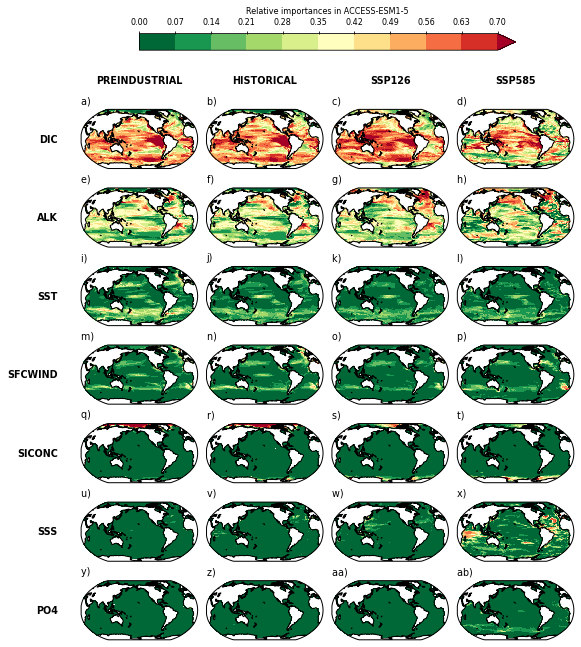

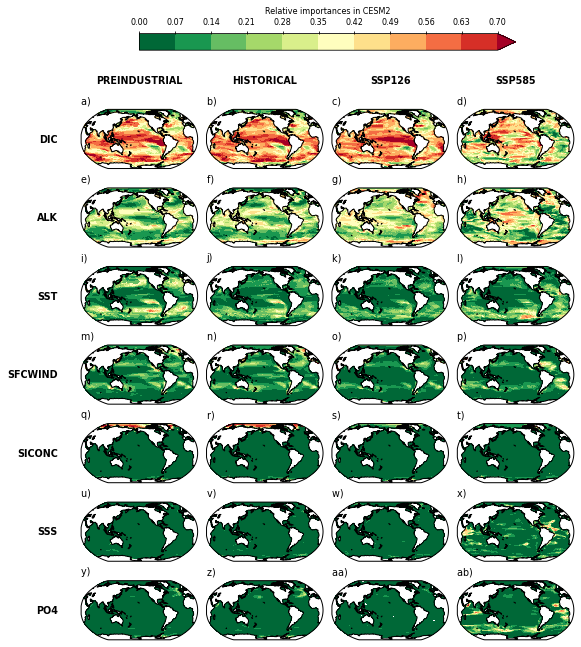

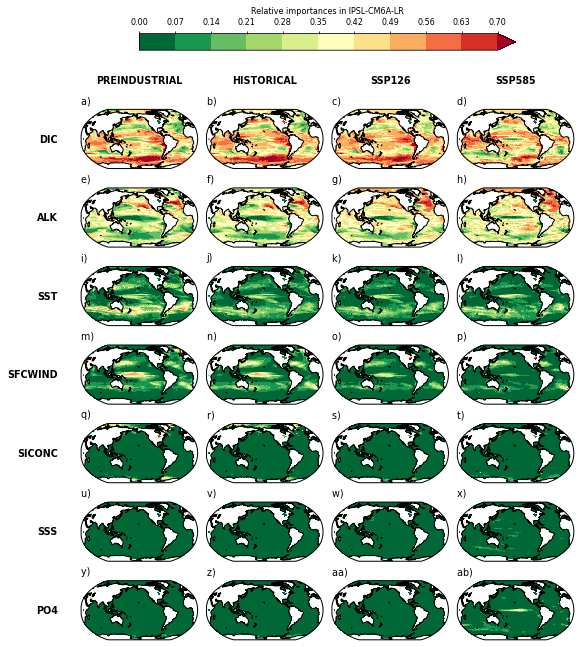

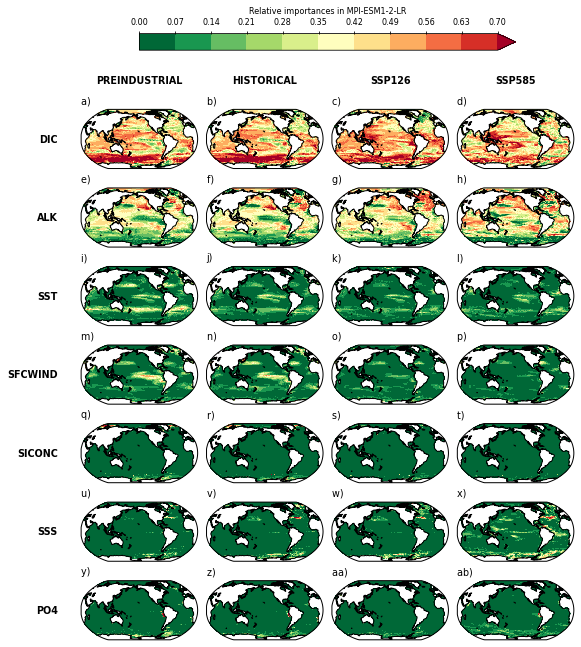

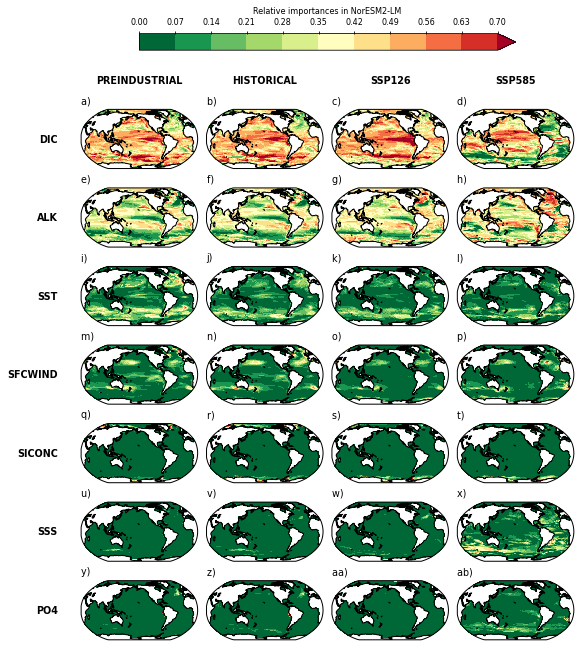

In [49]:
%%time
print(datetime.datetime.now())
print('Maps of FI for each models and each simulations: plot')


for imodel, vmodel in enumerate(model_list): 

    print('> model: '+vmodel)
    
    simu_list  = ['picontrol', 'historical', 'ssp126', 'ssp585']
    feature_list = ['dissic', 'talk', 'tos', 'sfcWind', 'siconc', 'sos', 'po4']

    #-----------------
    # FIGURE PARAM
    #-----------------

    nrow = len(feature_list)
    ncol = len(simu_list)
    fsize = (18*cm2in, 20*cm2in) # width height
    ccrsproj = ccrs.Robinson(central_longitude=-155)
    fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                           subplot_kw=dict(projection=ccrsproj),
                           squeeze = False)

    subnum = list('abcdefghijklmnopqrstuvwxyz')
    aaa=[]
    for sss in subnum: aaa.append('a'+sss)
    subnum=subnum+aaa
    subnum.reverse()

    #-----------------
    # CREATE CUSTOM CMAP
    #-----------------

    zw = cm.get_cmap('RdYlGn_r', 256)
    newcolors = zw(np.linspace(0, 1, 10+1))
    cmap1 = ListedColormap(newcolors[:-1])
    cmap1.set_under(color='silver')
    cmap1.set_over (color=newcolors[-1])
    cmap1.set_bad(color='silver', alpha=0)


    #-----------------
    # KEYWORDS DICT
    #-----------------

    kwmap = {'vmin':0, 'vmax':0.7, 'cmap':cmap1, \
             'transform':ccrs.PlateCarree() }

    #-----------------
    # Maps
    #-----------------

    mmm = np.zeros_like(ax)    
    for isimu, vsimu in enumerate(simu_list):

        print('>> simu: ' + vsimu)

        for ifeature, vfeature in enumerate(feature_list): 
            
            zax = ax[ifeature, isimu]

            X = data2plot[vmodel][vsimu][vfeature]['X']
            Y = data2plot[vmodel][vsimu][vfeature]['Y']
            Z = data2plot[vmodel][vsimu][vfeature]['Z']
            
            mmm[ifeature, isimu] = zax.pcolormesh(X, Y, Z, **kwmap)
            zax.coastlines()

        #
    #
    fig.tight_layout()
    
    #---------------------
    # Add numbering to titles of subplots
    #---------------------

    for irow, axrow in enumerate(ax): 
        for zax in axrow: 
            zwtitle = subnum.pop() + ') '
            zax.set_title(zwtitle, loc='left')
        #
    #

    #---------------------
    # Colorbar
    #---------------------

    zw1 = ax[0,  0].get_position()
    zw2 = ax[0, -1].get_position()
    nx0 = zw1.x0 + .5*zw1.width
    ny0 = zw1.y1 + 1*zw1.height
    nw  = zw2.x1 - .5*zw2.width - nx0
    nh  = 0.04*nw
    cax = fig.add_axes([nx0, ny0, nw, nh])
    cbar = fig.colorbar(mmm[0, -1], cax=cax, ticklocation='top', 
                        orientation='horizontal', extend='max', 
                        label='Relative importances in '+vmodel)
    cbar.set_ticks(np.linspace(kwmap['vmin'], kwmap['vmax'], mmm[0, 0].cmap.colors.shape[0]+1))


    #---------------------
    # Add text on the left: feature names
    #---------------------

    kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='right', va='center')
    for ifeature, vfeature in enumerate(feature_list): 
        zw1 = ax[ifeature, 0].get_position()
        ny0 = 0.5 *(zw1.y0+zw1.y1)
        nx0 = zw1.x0 - .2*zw1.width
        fig.text(nx0, ny0, feature_name[vfeature].upper(), **kwtxt)
    #

    #---------------------
    # Add text on the top: simu names
    #---------------------

    kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='center', va='bottom')
    for isimu, vsimu in enumerate(simu_list): 
        zw1 = ax[0, isimu].get_position()
        nx0 = 0.5 *(zw1.x0+zw1.x1)
        ny0 = zw1.y1 + .4*zw1.height
        fig.text(nx0, ny0, simu_name[vsimu].upper(), **kwtxt)
    #

    #---------------------
    # Save figure
    #---------------------

    fignam = 'maps-fi-'+vmodel+'.png'
    fig.savefig(dirout+fignam, bbox_inches='tight')
    print('Figure saved: '+fignam)

#

# ca. 2m30s

# Maps of the sum of FI for DIC and ALK

row = each model, col = each simu

## Inputs

In [50]:
%%time
print(datetime.datetime.now())
print('Maps of the sum of FI for DIC and ALK: inputs')

model_list = ['ACCESS-ESM1-5', 'CESM2', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'NorESM2-LM']
simu_list  = ['picontrol', 'historical', 'ssp126', 'ssp585']
grid = '360x180'

feature_name = {
    'siconc' :'siconc', 
    'talk'   :'ALK',
    'dissic' :'DIC', 
    'tos'    :'SST', 
    'sfcWind':'sfcWind', 
    'sos'    :'SSS', 
    'po4'    :'PO4', 
    'atmco2' :'atmCO2'    
}
simu_name = {
    'picontrol': 'preindustrial', 
    'historical': 'historical', 
    'ssp126': 'SSP126', 
    'ssp585': 'SSP585'
}


2022-11-21 17:28:01.090926
Maps of the sum of FI for DIC and ALK: inputs
CPU times: user 2.1 ms, sys: 179 µs, total: 2.28 ms
Wall time: 520 µs


## Prepare data2plot

In [51]:
%%time
print(datetime.datetime.now())
print('Maps of the sum of FI for DIC and ALK: prepare data2plot')

data2plot = {}
for imodel, vmodel in enumerate(model_list): 
    
    print('> model: '+vmodel)
    data2plot[vmodel] = {}
    
    for isimu, vsimu in enumerate(simu_list):

        print('>> simu: ' + vsimu)
        data2plot[vmodel][vsimu] = {}

        print('>>> Load datas')
        savedfile = dirshared + 'fi-std-' + vmodel + '-' + vsimu + '-' + grid + '.pckl'
        with open(savedfile, 'rb') as f1: loadeddatas = pickle.load(f1)
        print("File loaded: "+savedfile)

        # Load features
        print('>>> Get features')
        data2plot[vmodel][vsimu] = {'X': loadeddatas['lon'].T, 
                                    'Y': loadeddatas['lat'].T, 
                                    'Z': loadeddatas['dissic']['avg'].T+loadeddatas['talk']['avg'].T}
        #
    #
#

# ca. 1s

2022-11-21 17:28:01.101968
Maps of the sum of FI for DIC and ALK: prepare data2plot
> model: ACCESS-ESM1-5
>> simu: picontrol
>>> Load datas
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/fi-std-ACCESS-ESM1-5-picontrol-360x180.pckl
>>> Get features
>> simu: historical
>>> Load datas
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/fi-std-ACCESS-ESM1-5-historical-360x180.pckl
>>> Get features
>> simu: ssp126
>>> Load datas
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/fi-std-ACCESS-ESM1-5-ssp126-360x180.pckl
>>> Get features
>> simu: ssp585
>>> Load datas
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/fi-std-ACCESS-ESM1-5-ssp585-360x180.pckl
>>> Get features
> model: CESM2
>> simu: picontrol
>>> Load datas
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/fi-std-CESM2-picontrol-360x180.pckl
>>> Get features
>> simu: historical
>>> Load da

## Plot

2022-11-21 17:28:01.244445
Maps of the sum of FI for DIC and ALK: plot
> model: ACCESS-ESM1-5
>> simu: picontrol
>> simu: historical
>> simu: ssp126
>> simu: ssp585
> model: CESM2
>> simu: picontrol
>> simu: historical
>> simu: ssp126
>> simu: ssp585
> model: IPSL-CM6A-LR
>> simu: picontrol
>> simu: historical
>> simu: ssp126
>> simu: ssp585
> model: MPI-ESM1-2-LR
>> simu: picontrol
>> simu: historical
>> simu: ssp126
>> simu: ssp585
> model: NorESM2-LM
>> simu: picontrol
>> simu: historical
>> simu: ssp126
>> simu: ssp585
Figure saved: maps-sum-fi-dic-alk.png
CPU times: user 25.7 s, sys: 2.77 s, total: 28.4 s
Wall time: 21.2 s


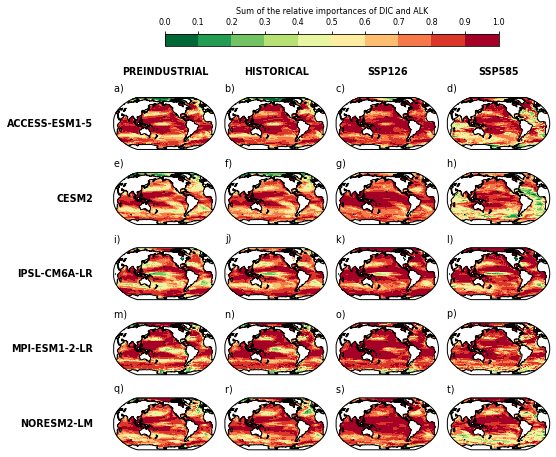

In [52]:
%%time
print(datetime.datetime.now())
print('Maps of the sum of FI for DIC and ALK: plot')

#-----------------
# FIGURE PARAM
#-----------------

nrow = len(model_list)
ncol = len(simu_list)
fsize = (16*cm2in, 14*cm2in) # width height
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# CREATE CUSTOM CMAP
#-----------------

zw = cm.get_cmap('RdYlGn_r', 256)
newcolors = zw(np.linspace(0, 1, 10))
cmap1 = ListedColormap(newcolors)
cmap1.set_under(color='silver')
cmap1.set_over (color='silver')
cmap1.set_bad(color='silver', alpha=0)

#-----------------
# KEYWORDS DICT
#-----------------

kwmap = {'vmin':0, 'vmax':1., 'cmap':cmap1, \
         'transform':ccrs.PlateCarree() }

#-----------------
# Maps
#-----------------

mmm = np.zeros_like(ax)    
for imodel, vmodel in enumerate(model_list): 

    print('> model: '+vmodel)

    for isimu, vsimu in enumerate(simu_list):

        print('>> simu: ' + vsimu)

        zax = ax[imodel, isimu]

        X = data2plot[vmodel][vsimu]['X']
        Y = data2plot[vmodel][vsimu]['Y']
        Z = data2plot[vmodel][vsimu]['Z']

        mmm[imodel, isimu] = zax.pcolormesh(X, Y, Z, **kwmap)
        zax.coastlines()
    #
#

fig.tight_layout()
    
#---------------------
# Add numbering to titles of subplots
#---------------------

for irow, axrow in enumerate(ax): 
    for zax in axrow: 
        zwtitle = subnum.pop() + ') '
        zax.set_title(zwtitle, loc='left')
    #
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0,  0].get_position()
zw2 = ax[0, -1].get_position()
nx0 = zw1.x0 + .5*zw1.width
ny0 = zw1.y1 + 1*zw1.height
nw  = zw2.x1 - .5*zw2.width - nx0
nh  = 0.04*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(mmm[0, -1], cax=cax, ticklocation='top', 
                    orientation='horizontal', extend='neither', 
                    label='Sum of the relative importances of DIC and ALK')
cbar.set_ticks(np.linspace(kwmap['vmin'], kwmap['vmax'], mmm[0, 0].cmap.colors.shape[0]+1))


#---------------------
# Add text on the left: model names
#---------------------

kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='right', va='center')
for imodel, vmodel in enumerate(model_list): 
    zw1 = ax[imodel, 0].get_position()
    ny0 = 0.5 *(zw1.y0+zw1.y1)
    nx0 = zw1.x0 - .2*zw1.width
    fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
#

#---------------------
# Add text on the top: simu names
#---------------------

kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='center', va='bottom')
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[0, isimu].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .4*zw1.height
    fig.text(nx0, ny0, simu_name[vsimu].upper(), **kwtxt)
#

#---------------------
# Save figure
#---------------------

fignam = 'maps-sum-fi-dic-alk.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)


# ca. 2m30s

## Histogram

2022-11-21 17:28:24.951407
Histogram


/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater


Figure saved: histogram-sum-fi-dic-alk.png
CPU times: user 6.87 s, sys: 186 ms, total: 7.06 s
Wall time: 6.84 s


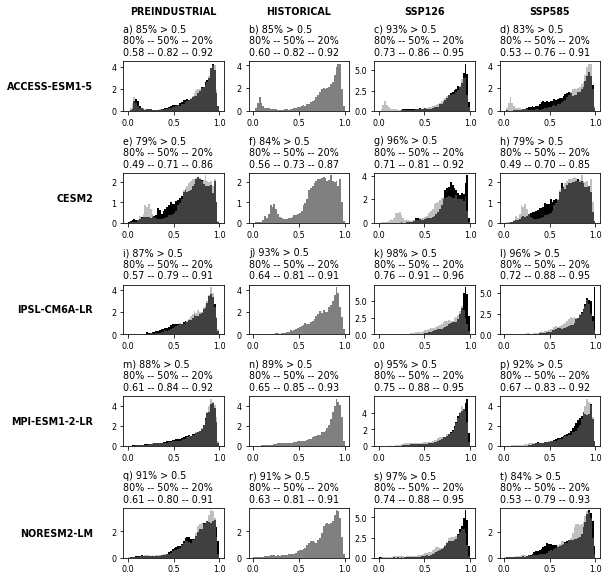

In [53]:
%%time
print(datetime.datetime.now())
print('Histogram')

#-----------------
# FIGURE PARAM
#-----------------

nrow = len(model_list)
ncol = len(simu_list)
fsize = (18*cm2in, 20*cm2in) # width height
fig, ax = plt.subplots(nrow, ncol, figsize=fsize,
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# KEYWORDS DICT
#-----------------

kwhist = dict(bins=50, range=[0, 1], density=True, color='black')
kwhist2 = dict(bins=50, range=[0, 1], density=True, color='grey')
kwlines = dict(color='gray', ls='--')

#---------------------
# Plot histograms
#---------------------

for imodel, vmodel in enumerate(model_list): 
    
    for isimu, vsimu in enumerate(simu_list): 

        zax = ax[imodel, isimu]
        if vsimu == 'historical': 
            zwdata = data2plot[vmodel][vsimu]['Z'].flatten()
            pcm = zax.hist(zwdata, **kwhist2)    
        else: 
            zwdata = data2plot[vmodel][vsimu]['Z'].flatten()
            pcm = zax.hist(zwdata, **kwhist)    
            zwdatahist = data2plot[vmodel]['historical']['Z'].flatten()
            pcm = zax.hist(zwdatahist, alpha=.5, **kwhist2)    
        #
        quantile20 = np.nanquantile(zwdata, .2)
        quantile50 = np.nanquantile(zwdata, .5)
        quantile80 = np.nanquantile(zwdata, .8)
        zw= np.nonzero(zwdata  > .5)
        pctabove50 = len(zw[0])/len(np.where(zwdata==zwdata)[0])*100
        #zax.axhline(0.2, **kwlines)
        #zax.axvline(quantile20, **kwlines)
        zax.set_title(subnum.pop()+") %.0f%s > 0.5\n80%s -- 50%s -- 20%s\n%.2f -- %.2f -- %.2f"
                      %(pctabove50, "%", "%", "%", "%", quantile20, quantile50, quantile80), loc='left')
#
fig.tight_layout()

#---------------------
# Add text on the left: model names
#---------------------

kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='right', va='center')
for imodel, vmodel in enumerate(model_list): 
    zw1 = ax[imodel, 0].get_position()
    ny0 = 0.5 *(zw1.y0+zw1.y1)
    nx0 = zw1.x0 - .3*zw1.width
    fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
#

#---------------------
# Add text on the top: simu names
#---------------------

kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='center', va='bottom')
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[0, isimu].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .9*zw1.height
    fig.text(nx0, ny0, simu_name[vsimu].upper(), **kwtxt)
#


#---------------------
# Save figure
#---------------------

fignam = 'histogram-sum-fi-dic-alk.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# ca. 7s

# Maps of the ratio of FIDIC and FIALK

row = each model, col = each simu

## Inputs

In [54]:
%%time
print(datetime.datetime.now())
print('Maps of the ratio of FIDIC and FIALK: inputs')


model_list = ['ACCESS-ESM1-5', 'CESM2', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'NorESM2-LM']
simu_list  = ['picontrol', 'historical', 'ssp126', 'ssp585']
grid = '360x180'

feature_name = {
    'siconc' :'siconc', 
    'talk'   :'ALK',
    'dissic' :'DIC', 
    'tos'    :'SST', 
    'sfcWind':'sfcWind', 
    'sos'    :'SSS', 
    'po4'    :'PO4', 
    'atmco2' :'atmCO2'    
}
simu_name = {
    'picontrol': 'preindustrial', 
    'historical': 'historical', 
    'ssp126': 'SSP126', 
    'ssp585': 'SSP585'
}


2022-11-21 17:30:19.005781
Maps of the ratio of FIDIC and FIALK: inputs
CPU times: user 629 µs, sys: 0 ns, total: 629 µs
Wall time: 482 µs


## Prepare data2plot

In [55]:
%%time
print(datetime.datetime.now())
print('Maps of the ratio of FIDIC and FIALK: prepare data2plot')

data2plot = {}
for imodel, vmodel in enumerate(model_list): 
    
    print('> model: '+vmodel)
    data2plot[vmodel] = {}
    
    for isimu, vsimu in enumerate(simu_list):

        print('>> simu: ' + vsimu)
        data2plot[vmodel][vsimu] = {}

        print('>>> Load datas')
        savedfile = dirshared + 'fi-std-' + vmodel + '-' + vsimu + '-' + grid + '.pckl'
        with open(savedfile, 'rb') as f1: loadeddatas = pickle.load(f1)
        print("File loaded: "+savedfile)

        # Load features
        print('>>> Get features')
        data2plot[vmodel][vsimu] = {'X': loadeddatas['lon'].T, 
                                    'Y': loadeddatas['lat'].T, 
                                    'Z': loadeddatas['talk']['avg'].T/loadeddatas['dissic']['avg'].T}
        #
    #
#

# ca. 1s

2022-11-21 17:30:21.895206
Maps of the ratio of FIDIC and FIALK: prepare data2plot
> model: ACCESS-ESM1-5
>> simu: picontrol
>>> Load datas
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/fi-std-ACCESS-ESM1-5-picontrol-360x180.pckl
>>> Get features
>> simu: historical
>>> Load datas
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/fi-std-ACCESS-ESM1-5-historical-360x180.pckl
>>> Get features
>> simu: ssp126
>>> Load datas
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/fi-std-ACCESS-ESM1-5-ssp126-360x180.pckl
>>> Get features
>> simu: ssp585
>>> Load datas
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/fi-std-ACCESS-ESM1-5-ssp585-360x180.pckl
>>> Get features
> model: CESM2
>> simu: picontrol
>>> Load datas
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/fi-std-CESM2-picontrol-360x180.pckl
>>> Get features
>> simu: historical
>>> Load dat

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


## Plot

2022-11-21 17:30:51.266101
Maps of the ratio of FIDIC and FIALK: plot
> model: ACCESS-ESM1-5
>> simu: picontrol
>> simu: historical
>> simu: ssp126
>> simu: ssp585
> model: CESM2
>> simu: picontrol
>> simu: historical
>> simu: ssp126
>> simu: ssp585
> model: IPSL-CM6A-LR
>> simu: picontrol
>> simu: historical
>> simu: ssp126
>> simu: ssp585
> model: MPI-ESM1-2-LR
>> simu: picontrol
>> simu: historical
>> simu: ssp126
>> simu: ssp585
> model: NorESM2-LM
>> simu: picontrol
>> simu: historical
>> simu: ssp126
>> simu: ssp585
Figure saved: maps-ratio-fi-dic-alk.png
CPU times: user 25.2 s, sys: 2.63 s, total: 27.9 s
Wall time: 21 s


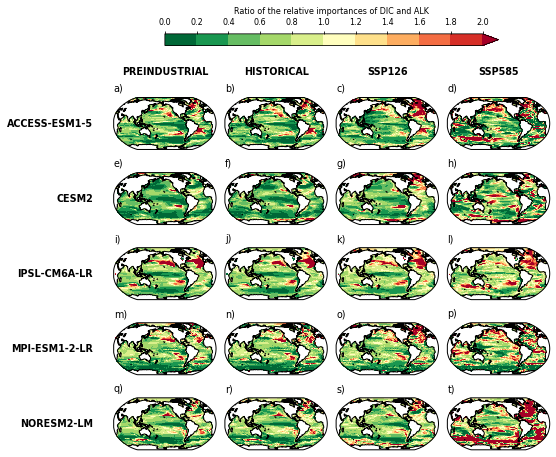

In [56]:
%%time
print(datetime.datetime.now())
print('Maps of the ratio of FIDIC and FIALK: plot')

#-----------------
# FIGURE PARAM
#-----------------

nrow = len(model_list)
ncol = len(simu_list)
fsize = (16*cm2in, 14*cm2in) # width height
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# CREATE CUSTOM CMAP
#-----------------

zw = cm.get_cmap('RdYlGn_r', 256)
newcolors = zw(np.linspace(0, 1, 10+1))
cmap1 = ListedColormap(newcolors[:-1])
cmap1.set_under(color='silver')
cmap1.set_over (color=newcolors[-1])
cmap1.set_bad(color='silver', alpha=0)

#-----------------
# KEYWORDS DICT
#-----------------

kwmap = {'vmin':0, 'vmax':2., 'cmap':cmap1, \
         'transform':ccrs.PlateCarree() }

#-----------------
# Maps
#-----------------

mmm = np.zeros_like(ax)    
for imodel, vmodel in enumerate(model_list): 

    print('> model: '+vmodel)

    for isimu, vsimu in enumerate(simu_list):

        print('>> simu: ' + vsimu)

        zax = ax[imodel, isimu]

        X = data2plot[vmodel][vsimu]['X']
        Y = data2plot[vmodel][vsimu]['Y']
        Z = data2plot[vmodel][vsimu]['Z']

        mmm[imodel, isimu] = zax.pcolormesh(X, Y, Z, **kwmap)
        zax.coastlines()
    #
#

fig.tight_layout()
    
#---------------------
# Add numbering to titles of subplots
#---------------------

for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow): 
        zwtitle = subnum.pop() + ')'
        zax.set_title(zwtitle, loc='left')
    #
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0,  0].get_position()
zw2 = ax[0, -1].get_position()
nx0 = zw1.x0 + .5*zw1.width
ny0 = zw1.y1 + 1*zw1.height
nw  = zw2.x1 - .5*zw2.width - nx0
nh  = 0.04*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(mmm[0, -1], cax=cax, ticklocation='top', 
                    orientation='horizontal', extend='max', 
                    label='Ratio of the relative importances of DIC and ALK')
cbar.set_ticks(np.linspace(kwmap['vmin'], kwmap['vmax'], mmm[0, 0].cmap.colors.shape[0]+1))


#---------------------
# Add text on the left: model names
#---------------------

kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='right', va='center')
for imodel, vmodel in enumerate(model_list): 
    zw1 = ax[imodel, 0].get_position()
    ny0 = 0.5 *(zw1.y0+zw1.y1)
    nx0 = zw1.x0 - .2*zw1.width
    fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
#

#---------------------
# Add text on the top: simu names
#---------------------

kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='center', va='bottom')
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[0, isimu].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .4*zw1.height
    fig.text(nx0, ny0, simu_name[vsimu].upper(), **kwtxt)
#

#---------------------
# Save figure
#---------------------

fignam = 'maps-ratio-fi-dic-alk.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)


# ca. 25s

## Histogram

2022-11-21 17:31:14.871035
Histogram


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater


Figure saved: histogram-ratio-fi-dic-alk.png
CPU times: user 6.89 s, sys: 163 ms, total: 7.05 s
Wall time: 6.78 s


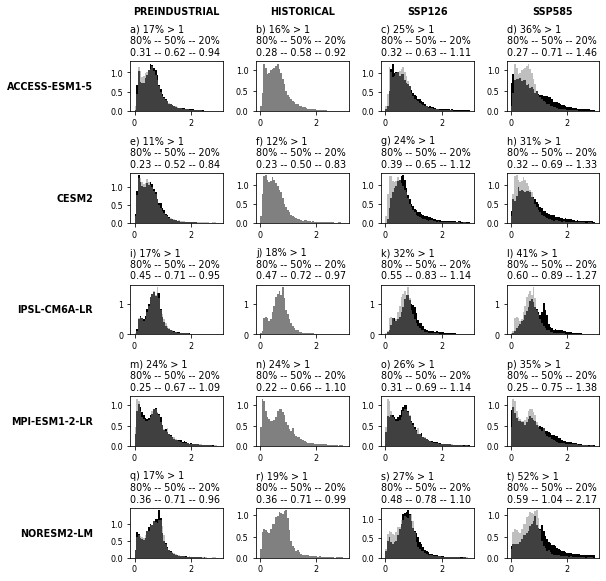

In [57]:
%%time
print(datetime.datetime.now())
print('Histogram')

#-----------------
# FIGURE PARAM
#-----------------

nrow = len(model_list)
ncol = len(simu_list)
fsize = (18*cm2in, 20*cm2in) # width height
fig, ax = plt.subplots(nrow, ncol, figsize=fsize,
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# KEYWORDS DICT
#-----------------

kwhist = dict(bins=50, range=[0, 3], density=True, color='black')
kwhist2 = dict(bins=50, range=[0, 3], density=True, color='grey')
kwlines = dict(color='gray', ls='--')

#---------------------
# Plot histograms
#---------------------

for imodel, vmodel in enumerate(model_list): 
    
    for isimu, vsimu in enumerate(simu_list): 

        zax = ax[imodel, isimu]
        if vsimu == 'historical': 
            zwdata = data2plot[vmodel][vsimu]['Z'].flatten()
            pcm = zax.hist(zwdata, **kwhist2)    
        else: 
            zwdata = data2plot[vmodel][vsimu]['Z'].flatten()
            pcm = zax.hist(zwdata, **kwhist)    
            zwdatahist = data2plot[vmodel]['historical']['Z'].flatten()
            pcm = zax.hist(zwdatahist, alpha=.5, **kwhist2)    

        quantile20 = np.nanquantile(zwdata, .2)
        quantile50 = np.nanquantile(zwdata, .5)
        quantile80 = np.nanquantile(zwdata, .8)
        zw= np.nonzero(zwdata  > 1.)
        pctabove50 = len(zw[0])/len(np.where(zwdata==zwdata)[0])*100
        #zax.axhline(0.2, **kwlines)
        #zax.axvline(quantile20, **kwlines)
        zax.set_title(subnum.pop()+") %.0f%s > 1\n80%s -- 50%s -- 20%s\n%.2f -- %.2f -- %.2f"
                      %(pctabove50, "%", "%", "%", "%", quantile20, quantile50, quantile80), loc='left')

#
fig.tight_layout()

#---------------------
# Add text on the left: model names
#---------------------

kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='right', va='center')
for imodel, vmodel in enumerate(model_list): 
    zw1 = ax[imodel, 0].get_position()
    ny0 = 0.5 *(zw1.y0+zw1.y1)
    nx0 = zw1.x0 - .4*zw1.width
    fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
#

#---------------------
# Add text on the top: simu names
#---------------------

kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='center', va='bottom')
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[0, isimu].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .9*zw1.height
    fig.text(nx0, ny0, simu_name[vsimu].upper(), **kwtxt)
#


#---------------------
# Save figure
#---------------------

fignam = 'histogram-ratio-fi-dic-alk.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# ca. 7s

# Maps of variance of DIC and ALK

one figure for DIC, one for ALK, one for DICsn, on for ALKsn

row = model, col = simu

## Input

In [58]:
%%time
print(datetime.datetime.now())
print('Maps of variance of DIC and ALK: input')

data2plot_dir = dirroot + 'dimred-220513-predictors-variances/'
model_list = ['ACCESS-ESM1-5', 'CESM2', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'NorESM2-LM']
simu_list  = ['historical', 'ssp126', 'ssp585']
var_list   = ['dissic', 'dissic_sn', 'talk', 'talk_sn']

namevar_dict = {
    'dissic'   : 'DIC'   , 
    'talk'     : 'ALK'   , 
    'dissic_sn': 'DIC-sn', 
    'talk_sn'  : 'ALK-sn'
}


simu_name = {
    'picontrol': 'preindustrial', 
    'historical': 'historical', 
    'ssp126': 'SSP126', 
    'ssp585': 'SSP585'
}


zfact = 1e3 # mol.m-3 to mmol.m-3 (or umol.l)

2022-11-21 17:32:58.921931
Maps of variance of DIC and ALK: input
CPU times: user 627 µs, sys: 0 ns, total: 627 µs
Wall time: 420 µs


## Plot

2022-11-21 17:32:59.948785
Maps of variance of DIC and ALK: plot
> model: ACCESS-ESM1-5
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/dimred-220513-predictors-variances/data2plot-variances-of-dtrd-deseas-dic-alk-dicsn-alksn-ACCESS-ESM1-5.pckl
>> simu: historical
>> simu: ssp126
>> simu: ssp585
> model: CESM2
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/dimred-220513-predictors-variances/data2plot-variances-of-dtrd-deseas-dic-alk-dicsn-alksn-CESM2.pckl
>> simu: historical
>> simu: ssp126
>> simu: ssp585
> model: IPSL-CM6A-LR
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/dimred-220513-predictors-variances/data2plot-variances-of-dtrd-deseas-dic-alk-dicsn-alksn-IPSL-CM6A-LR.pckl
>> simu: historical
>> simu: ssp126
>> simu: ssp585
> model: MPI-ESM1-2-LR
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/dimred-220513-predictors-variances/data2plot-variances-of-dtrd-deseas-dic-alk-dicsn-alksn-MPI-ESM1-2-LR.pckl
>> simu: 

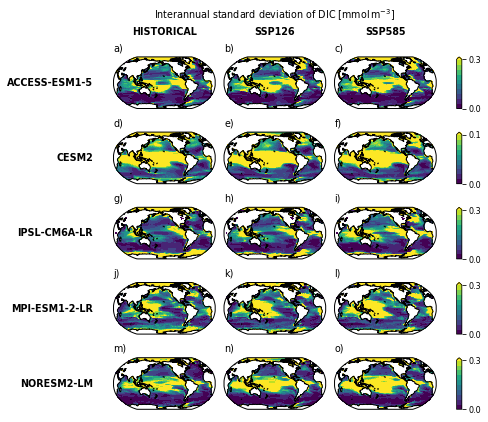

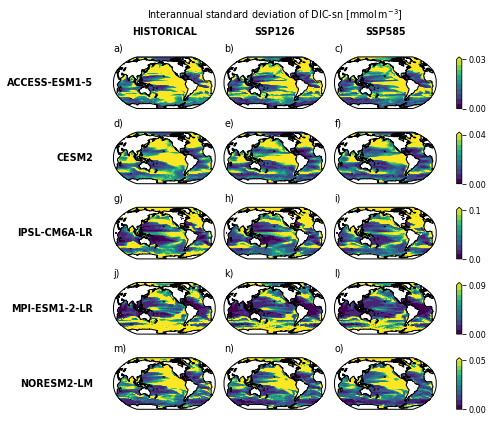

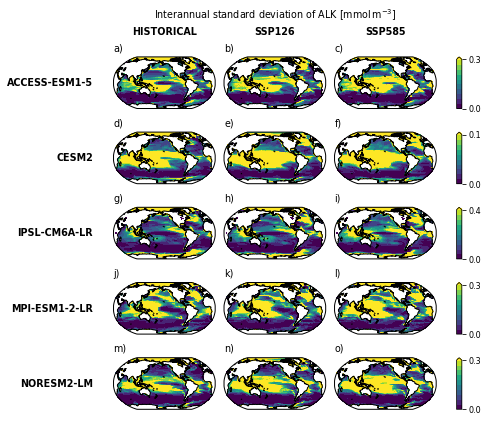

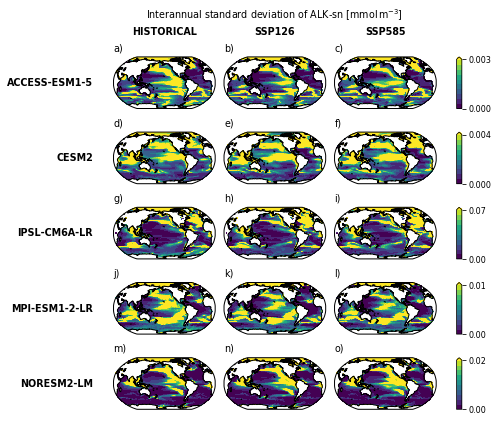

In [59]:
%%time
print(datetime.datetime.now())
print('Maps of variance of DIC and ALK: plot')

for vvar in var_list: 
    
    #-----------------
    # FIGURE PARAM
    #-----------------

    nrow = len(model_list)
    ncol = len(simu_list)
    fsize = (12*cm2in, 14*cm2in) # width height
    ccrsproj = ccrs.Robinson(central_longitude=-155)
    fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                           subplot_kw=dict(projection=ccrsproj),
                           squeeze = False)

    subnum = list('abcdefghijklmnopqrstuvwxyz')
    aaa=[]
    for sss in subnum: aaa.append('a'+sss)
    subnum=subnum+aaa
    subnum.reverse()

    #-----------------
    # CREATE CUSTOM CMAP
    #-----------------

    zw = cm.get_cmap('viridis', 256)
    newcolors = zw(np.linspace(0, 1, 10+1))
    cmap1 = ListedColormap(newcolors[:-1])
    cmap1.set_under(color='silver')
    cmap1.set_over (color=newcolors[-1])
    cmap1.set_bad(color='silver', alpha=0)

    #-----------------
    # KEYWORDS DICT
    #-----------------
    
    kwmap = {'cmap':cmap1, 'transform':ccrs.PlateCarree() }

    #-----------------
    # Maps
    #-----------------

    mmm = np.zeros_like(ax)    
    vmin, vmax = {}, {}
    for imodel, vmodel in enumerate(model_list): 

        print('> model: '+vmodel)
        
        #__________
        # Load data2plot
        data2plot_file = data2plot_dir + 'data2plot-variances-of-dtrd-deseas-dic-alk-dicsn-alksn-'+vmodel+'.pckl'
        with open(data2plot_file, 'rb') as f1: data2plot = pickle.load(f1)
        print("File loaded: "+data2plot_file)       

        #__________
        # define vmin and vmax
        zw = []
        for simu in simu_list: 
            zw.extend(data2plot[vvar][simu]['Z'].flatten() * zfact)        
        #
        zwvmin = 0
        zwvmax = np.nanquantile(zw, 0.7)
        f=np.floor(np.log10(zwvmax))
        zwvmax = np.round(zwvmax*10**(-f))*10**f
        vmax[vmodel] = zwvmax
        vmin[vmodel] = zwvmin

        #__________
        # Plot
        for isimu, vsimu in enumerate(simu_list):

            print('>> simu: ' + vsimu)

            zax = ax[imodel, isimu]

            X = data2plot[vvar][vsimu]['X']
            Y = data2plot[vvar][vsimu]['Y']
            Z = data2plot[vvar][vsimu]['Z'] * zfact

            mmm[imodel, isimu] = zax.pcolormesh(X, Y, Z, vmin = zwvmin, vmax = zwvmax, **kwmap)
            zax.coastlines()
        #
        
    #

    fig.tight_layout()

    #---------------------
    # Add numbering to titles of subplots
    #---------------------

    for irow, axrow in enumerate(ax): 
        for icol, zax in enumerate(axrow): 
            zwtitle = subnum.pop() + ')'
            zax.set_title(zwtitle, loc='left')
        #
    #

    #---------------------
    # Colorbar
    #---------------------

    # zw1 = ax[0,  0].get_position()
    # zw2 = ax[0, -1].get_position()
    # nx0 = zw1.x0 + .5*zw1.width
    # ny0 = zw1.y1 + 1*zw1.height
    # nw  = zw2.x1 - .5*zw2.width - nx0
    # nh  = 0.04*nw
    # cax = fig.add_axes([nx0, ny0, nw, nh])
    # cbar = fig.colorbar(mmm[0, -1], cax=cax, ticklocation='top', 
    #                     orientation='horizontal', extend='max', 
    #                     label='Interannual standard deviation of %s [mmol$\,$m$^{-3}$]' %namevar_dict[vvar])
    # cbar.set_ticks( np.linspace( kwmap['vmin'], kwmap['vmax'], np.int(mmm[0, 0].cmap.colors.shape[0]/2+1) ) )

    for imodel, vmodel in enumerate(model_list): 
        zw1 = ax[imodel,  -1].get_position()
        nx0 = zw1.x1 + .2*zw1.width
        ny0 = zw1.y0
        nh  = zw1.height
        nw  = 0.12*nh
        cax = fig.add_axes([nx0, ny0, nw, nh])
        cbar = fig.colorbar(mmm[imodel, -1], cax=cax, ticklocation='right', 
                            orientation='vertical', extend='max')
        cbar.set_ticks([vmin[vmodel], vmax[vmodel]])
    #
    
    #---------------------
    # Add text on the left: model names
    #---------------------

    kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='right', va='center')
    for imodel, vmodel in enumerate(model_list): 
        zw1 = ax[imodel, 0].get_position()
        ny0 = 0.5 *(zw1.y0+zw1.y1)
        nx0 = zw1.x0 - .2*zw1.width
        fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
    #

    #---------------------
    # Add text on the top: simu names
    #---------------------

    kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='center', va='bottom')
    for isimu, vsimu in enumerate(simu_list): 
        zw1 = ax[0, isimu].get_position()
        nx0 = 0.5 *(zw1.x0+zw1.x1)
        ny0 = zw1.y1 + .4*zw1.height
        fig.text(nx0, ny0, simu_name[vsimu].upper(), **kwtxt)
    #

    stitle='Interannual standard deviation of %s [mmol$\,$m$^{-3}$]' %namevar_dict[vvar]
    fig.suptitle(stitle, y=1.07)

    #---------------------
    # Save figure
    #---------------------

    fignam = 'maps-variance-'+namevar_dict[vvar].lower()+'.png'
    fig.savefig(dirout+fignam, bbox_inches='tight')
    print('Figure saved: '+fignam)

#

# ca. 2m30s

## Plot delta

2022-11-21 17:34:13.957546
Maps of variance of DIC and ALK: plot delta
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/dimred-220513-predictors-variances/data2plot-variances-of-dtrd-deseas-dic-alk-dicsn-alksn-ACCESS-ESM1-5.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/dimred-220513-predictors-variances/data2plot-variances-of-dtrd-deseas-dic-alk-dicsn-alksn-CESM2.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/dimred-220513-predictors-variances/data2plot-variances-of-dtrd-deseas-dic-alk-dicsn-alksn-IPSL-CM6A-LR.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/dimred-220513-predictors-variances/data2plot-variances-of-dtrd-deseas-dic-alk-dicsn-alksn-MPI-ESM1-2-LR.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/dimred-220513-predictors-variances/data2plot-variances-of-dtrd-deseas-dic-alk-dicsn-alksn-NorESM2-LM.pckl
> model: ACCESS-ESM1-5
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_N

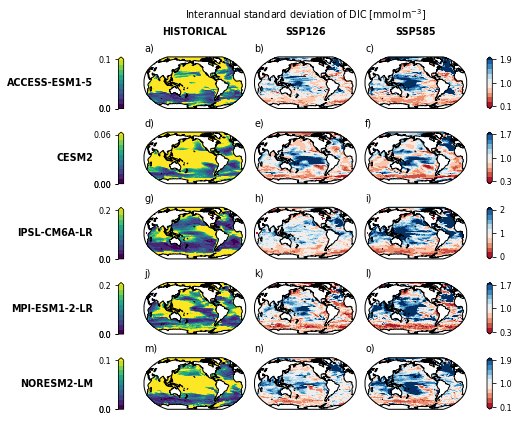

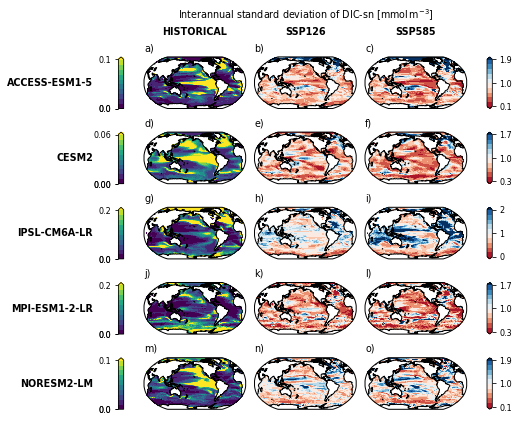

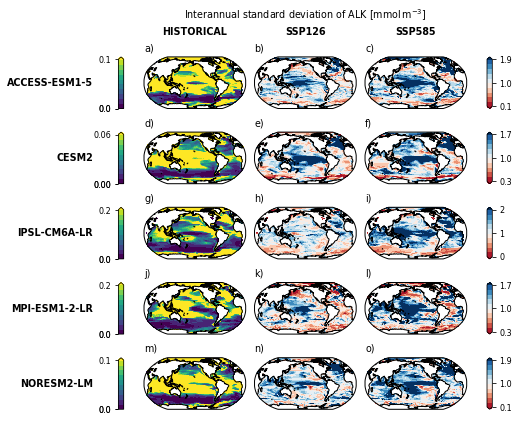

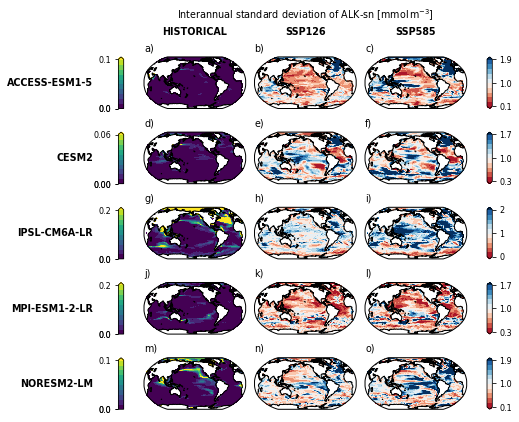

In [60]:
%%time
print(datetime.datetime.now())
print('Maps of variance of DIC and ALK: plot delta')

# var_list   = ['dissic_sn', 'talk_sn']

#-----------------
# define vmin and vmax
#-----------------

vmin, vmax = {}, {}
for imodel, vmodel in enumerate(model_list): 
    vmin[vmodel], vmax[vmodel] = {}, {}

    #__________
    # Load data2plot
    data2plot_file = data2plot_dir + 'data2plot-variances-of-dtrd-deseas-dic-alk-dicsn-alksn-'+vmodel+'.pckl'
    with open(data2plot_file, 'rb') as f1: data2plot = pickle.load(f1)
    print("File loaded: "+data2plot_file)       

    zwhist = []
    for vvar in var_list: zwhist.extend( data2plot[vvar]['historical']['Z'].flatten() * zfact )    
    zwvmax = np.nanquantile(zwhist, 0.7)
    f=np.floor(np.log10(zwvmax))
    zwvmax = np.round(zwvmax*10**(-f))*10**f
    vmax[vmodel]['hist'] = zwvmax
    vmin[vmodel]['hist'] = 0

    zwssp = []
    for simu in ['ssp126', 'ssp585']: 
        for vvar in var_list:
            zw = data2plot[vvar][simu]['Z'].flatten() / data2plot[vvar]['historical']['Z'].flatten() - 1
            zwssp.extend( np.abs(zw) )
        #
    #
    zwvmax = np.nanquantile(zwssp, 0.9)
    f=np.floor(np.log10(zwvmax))
    zwvmax = np.round(zwvmax*10**(-f))*10**f
    vmax[vmodel]['ssps'] = 1+zwvmax
    vmin[vmodel]['ssps'] = 1-zwvmax
#



for vvar in var_list: 
    
    #-----------------
    # FIGURE PARAM
    #-----------------

    nrow = len(model_list)
    ncol = len(simu_list)
    fsize = (12*cm2in, 14*cm2in) # width height
    ccrsproj = ccrs.Robinson(central_longitude=-155)
    fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                           subplot_kw=dict(projection=ccrsproj),
                           squeeze = False)

    subnum = list('abcdefghijklmnopqrstuvwxyz')
    aaa=[]
    for sss in subnum: aaa.append('a'+sss)
    subnum=subnum+aaa
    subnum.reverse()

    #-----------------
    # CREATE CUSTOM CMAP
    #-----------------

    zw = cm.get_cmap('viridis', 256)
    newcolors = zw(np.linspace(0, 1, 10+1))
    cmap1 = ListedColormap(newcolors[:-1])
    cmap1.set_under(color='silver')
    cmap1.set_over (color=newcolors[-1])
    cmap1.set_bad(color='silver', alpha=0)

    zw = cm.get_cmap('RdBu', 256)
    newcolors = zw(np.linspace(0, 1, 10+2))
    cmap2 = ListedColormap(newcolors[1:-1])
    cmap2.set_under(color=newcolors[1])
    cmap2.set_over (color=newcolors[-1])
    cmap2.set_bad(color='silver', alpha=0)

    #-----------------
    # KEYWORDS DICT
    #-----------------
    
    kwmap1 = {'cmap':cmap1, 'transform':ccrs.PlateCarree() }
    kwmap2 = {'cmap':cmap2, 'transform':ccrs.PlateCarree() }

    #-----------------
    # Maps
    #-----------------

    mmm = np.zeros_like(ax)    
    for imodel, vmodel in enumerate(model_list): 

        print('> model: '+vmodel)
        
        #__________
        # Load data2plot
        data2plot_file = data2plot_dir + 'data2plot-variances-of-dtrd-deseas-dic-alk-dicsn-alksn-'+vmodel+'.pckl'
        with open(data2plot_file, 'rb') as f1: data2plot = pickle.load(f1)
        print("File loaded: "+data2plot_file)       

        #__________
        # Plot
        for isimu, vsimu in enumerate(simu_list):

            print('>> simu: ' + vsimu)

            zax = ax[imodel, isimu]

            X = data2plot[vvar][vsimu]['X']
            Y = data2plot[vvar][vsimu]['Y']

            if vsimu == 'historical':                 
                Z = data2plot[vvar][vsimu]['Z'] * zfact
                mmm[imodel, isimu] = zax.pcolormesh(X, Y, Z, vmin = vmin[vmodel]['hist'] , vmax = vmax[vmodel]['hist'], **kwmap1)
            else: 
                Z = ( data2plot[vvar][vsimu]['Z'] / data2plot[vvar]['historical']['Z'] )
                mmm[imodel, isimu] = zax.pcolormesh(X, Y, Z, vmin = vmin[vmodel]['ssps'], vmax = vmax[vmodel]['ssps'], **kwmap2)
            #
            zax.coastlines()
        #
        
    #

    fig.tight_layout()

    #---------------------
    # Add numbering to titles of subplots
    #---------------------

    for irow, axrow in enumerate(ax): 
        for icol, zax in enumerate(axrow): 
            zwtitle = subnum.pop() + ')'
            zax.set_title(zwtitle, loc='left')
        #
    #

    #---------------------
    # Colorbar
    #---------------------

    # zw1 = ax[0,  0].get_position()
    # zw2 = ax[0, -1].get_position()
    # nx0 = zw1.x0 + .5*zw1.width
    # ny0 = zw1.y1 + 1*zw1.height
    # nw  = zw2.x1 - .5*zw2.width - nx0
    # nh  = 0.04*nw
    # cax = fig.add_axes([nx0, ny0, nw, nh])
    # cbar = fig.colorbar(mmm[0, -1], cax=cax, ticklocation='top', 
    #                     orientation='horizontal', extend='max', 
    #                     label='Interannual standard deviation of %s [mmol$\,$m$^{-3}$]' %namevar_dict[vvar])
    # cbar.set_ticks( np.linspace( kwmap['vmin'], kwmap['vmax'], np.int(mmm[0, 0].cmap.colors.shape[0]/2+1) ) )

    for imodel, vmodel in enumerate(model_list): 
        # Hist
        zw1 = ax[imodel,  0].get_position()
        nx0 = zw1.x0 - .2*zw1.width
        ny0 = zw1.y0
        nh  = zw1.height
        nw  = 0.12*nh
        cax = fig.add_axes([nx0-nw, ny0, nw, nh])
        cbar = fig.colorbar(mmm[imodel, 0], cax=cax, ticklocation='left', 
                            orientation='vertical', extend='max')
        cbar.set_ticks([vmin[vmodel]['hist'], 0, vmax[vmodel]['hist']])
        # SSPs
        zw1 = ax[imodel,  -1].get_position()
        nx0 = zw1.x1 + .2*zw1.width
        ny0 = zw1.y0
        nh  = zw1.height
        nw  = 0.12*nh
        cax = fig.add_axes([nx0, ny0, nw, nh])
        cbar = fig.colorbar(mmm[imodel, -1], cax=cax, ticklocation='right', 
                            orientation='vertical', extend='both')
        cbar.set_ticks([vmin[vmodel]['ssps'], 1, vmax[vmodel]['ssps']])
    #
    
    #---------------------
    # Add text on the left: model names
    #---------------------

    kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='right', va='center')
    for imodel, vmodel in enumerate(model_list): 
        zw1 = ax[imodel, 0].get_position()
        ny0 = 0.5 *(zw1.y0+zw1.y1)
        nx0 = zw1.x0 - .5*zw1.width
        fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
    #

    #---------------------
    # Add text on the top: simu names
    #---------------------

    kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='center', va='bottom')
    for isimu, vsimu in enumerate(simu_list): 
        zw1 = ax[0, isimu].get_position()
        nx0 = 0.5 *(zw1.x0+zw1.x1)
        ny0 = zw1.y1 + .4*zw1.height
        fig.text(nx0, ny0, simu_name[vsimu].upper(), **kwtxt)
    #

    stitle='Interannual standard deviation of %s [mmol$\,$m$^{-3}$]' %namevar_dict[vvar]
    fig.suptitle(stitle, y=1.07)

    #---------------------
    # Save figure
    #---------------------

    fignam = 'maps-delta-variance-'+namevar_dict[vvar].lower()+'.png'
    fig.savefig(dirout+fignam, bbox_inches='tight')
    print('Figure saved: '+fignam)

#

# ca. 2m30s

## Plot delta DIC vs delta ALK

2022-11-21 17:35:28.245285
Maps of variance of DIC and ALK: plot delta DIC vs delta ALK
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/dimred-220513-predictors-variances/data2plot-variances-of-dtrd-deseas-dic-alk-dicsn-alksn-ACCESS-ESM1-5.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/dimred-220513-predictors-variances/data2plot-variances-of-dtrd-deseas-dic-alk-dicsn-alksn-CESM2.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/dimred-220513-predictors-variances/data2plot-variances-of-dtrd-deseas-dic-alk-dicsn-alksn-IPSL-CM6A-LR.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/dimred-220513-predictors-variances/data2plot-variances-of-dtrd-deseas-dic-alk-dicsn-alksn-MPI-ESM1-2-LR.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/dimred-220513-predictors-variances/data2plot-variances-of-dtrd-deseas-dic-alk-dicsn-alksn-NorESM2-LM.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOO

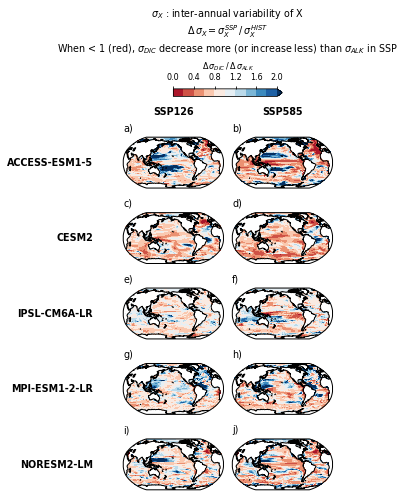

In [61]:
%%time
print(datetime.datetime.now())
print('Maps of variance of DIC and ALK: plot delta DIC vs delta ALK')

#-----------------
# Prepare data2plot
#-----------------

var_list   = ['dissic_sn', 'talk_sn']
simu_list = ['ssp126', 'ssp585']
data2plot = {}

for vvar in var_list: 

    data2plot[vvar] = {}
    
    for imodel, vmodel in enumerate(model_list): 
        
        data2plot[vvar][vmodel] = {}

        data2plot_file = data2plot_dir + 'data2plot-variances-of-dtrd-deseas-dic-alk-dicsn-alksn-'+vmodel+'.pckl'
        with open(data2plot_file, 'rb') as f1: loadeddatas = pickle.load(f1)
        print("File loaded: "+data2plot_file)       

        for isimu, vsimu in enumerate(simu_list):
            data2plot[vvar][vmodel][vsimu] = {}
            X = loadeddatas[vvar][vsimu]['X']
            Y = loadeddatas[vvar][vsimu]['Y']
            Z = ( loadeddatas[vvar][vsimu]['Z'] / loadeddatas[vvar]['historical']['Z'] )
            data2plot[vvar][vmodel][vsimu]['X'] = X
            data2plot[vvar][vmodel][vsimu]['Y'] = Y
            data2plot[vvar][vmodel][vsimu]['Z'] = Z
        #
    #
#


#-----------------
# FIGURE PARAM
#-----------------

nrow = len(model_list)
ncol = len(simu_list)
fsize = (8*cm2in, 14*cm2in) # width height
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# CREATE CUSTOM CMAP
#-----------------

zw = cm.get_cmap('RdBu', 256)
newcolors = zw(np.linspace(0, 1, 10+2))
cmap = ListedColormap(newcolors[1:-1])
cmap.set_under(color=newcolors[1])
cmap.set_over (color=newcolors[-1])
cmap.set_bad(color='silver', alpha=0)

#-----------------
# KEYWORDS DICT
#-----------------

kwmap = {'vmin':0, 'vmax':2, 'cmap':cmap, 'transform':ccrs.PlateCarree() }

#-----------------
# Maps
#-----------------

mmm = np.zeros_like(ax)    
for imodel, vmodel in enumerate(model_list): 

    for isimu, vsimu in enumerate(simu_list):

        zax = ax[imodel, isimu]

        X = data2plot['dissic_sn'][vmodel][vsimu]['X']
        Y = data2plot['dissic_sn'][vmodel][vsimu]['Y']
        Z = data2plot['dissic_sn'][vmodel][vsimu]['Z']/data2plot['talk_sn'][vmodel][vsimu]['Z']
        mmm[imodel, isimu] = zax.pcolormesh(X, Y, Z, **kwmap)
        zax.coastlines()
        
    #
#

fig.tight_layout()

#---------------------
# Add numbering to titles of subplots
#---------------------

for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow): 
        zwtitle = subnum.pop() + ')'
        zax.set_title(zwtitle, loc='left')
    #
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0,  0].get_position()
zw2 = ax[0, -1].get_position()
nx0 = zw1.x0 + .5*zw1.width
ny0 = zw1.y1 + .8*zw1.height
nw  = zw2.x1 - .5*zw2.width - nx0
nh  = 0.04*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(mmm[0, -1], cax=cax, ticklocation='top', 
                    orientation='horizontal', extend='max', 
                    label='$\Delta\,\sigma_{DIC}\,/\,\Delta\,\sigma_{ALK}$' )
cbar.set_ticks( np.linspace( kwmap['vmin'], kwmap['vmax'], np.int(mmm[0, 0].cmap.colors.shape[0]/2+1) ) )


#---------------------
# Add text on the left: model names
#---------------------

kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='right', va='center')
for imodel, vmodel in enumerate(model_list): 
    zw1 = ax[imodel, 0].get_position()
    ny0 = 0.5 *(zw1.y0+zw1.y1)
    nx0 = zw1.x0 - .3*zw1.width
    fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
#

#---------------------
# Add text on the top: simu names
#---------------------

kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='center', va='bottom')
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[0, isimu].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .4*zw1.height
    fig.text(nx0, ny0, simu_name[vsimu].upper(), **kwtxt)
#

stitle='$\sigma_{X}$ : inter-annual variability of X'+\
    '\n$\Delta\,\sigma_{X}=\sigma_{X}^{SSP}\,/\,\sigma_{X}^{HIST}$'+\
    '\nWhen < 1 (red), $\sigma_{DIC}$ decrease more (or increase less) than $\sigma_{ALK}$ in SSP'
fig.suptitle(stitle, y=1.15, va='bottom')

#---------------------
# Save figure
#---------------------

fignam = 'maps-ratio-delta-var-dic-delta-var-alk.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# ca. 13s

# Maps of changes in vertical gradient of DIC and ALK

one figure for DIC, one for ALK

row = model, col = simu

## Input

In [90]:
%%time
print(datetime.datetime.now())
print('Maps of changes in vertical gradient of DIC and ALK: input')

data2plot_dir_dict = {'dissic': dirroot+'DIC_GRADZ/', 
                      'talk'  : dirroot+'ALK_GRADZ/'}

model_list = ['ACCESS-ESM1-5', 'CESM2', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'NorESM2-LM']
period_list = ['1985-2014', '2071-2100']
var_list   = ['dissic', 'talk']


grad_depth_list = ['surf-250m', 'surf-500m']

namevar_dict = {
    'dissic'   : 'DIC'   , 
    'talk'     : 'ALK'   
}


2022-12-05 21:31:34.014501
Maps of changes in vertical gradient of DIC and ALK: input
CPU times: user 0 ns, sys: 578 µs, total: 578 µs
Wall time: 392 µs


## Define some functions

In [91]:
def read_grad_dic_datas(zwfname): 

    zwgridshape = (360, 180)
    zwdata = np.loadtxt(zwfname, dtype=str, delimiter=';')
    # zwdata = np.genfromtxt(zwfname, dtype=str)
    Z = np.array(np.where(zwdata.flatten()=='NA', np.nan, zwdata.flatten()).reshape(zwgridshape), dtype=float).T
        
    # X and Y are adapted for plt.pcolormesh with shading='flat'
    zwX = np.arange(-179.5, 179.5+1/2., 1) + 179.5
    zwY = np.arange(-89.5, 89.5+1/2., 1)
    X, Y = np.meshgrid(zwX, zwY)
    
    return Z, Y, X


## Plot

2022-11-21 17:36:32.948900
Maps of changes in vertical gradient of DIC and ALK: plot
Figure saved: maps-gradz-dic-surf-250m.png


/opt/conda/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


Figure saved: maps-gradz-dic-surf-500m.png
Figure saved: maps-gradz-alk-surf-250m.png
Figure saved: maps-gradz-alk-surf-500m.png
CPU times: user 1min 21s, sys: 9.94 s, total: 1min 31s
Wall time: 1min 6s


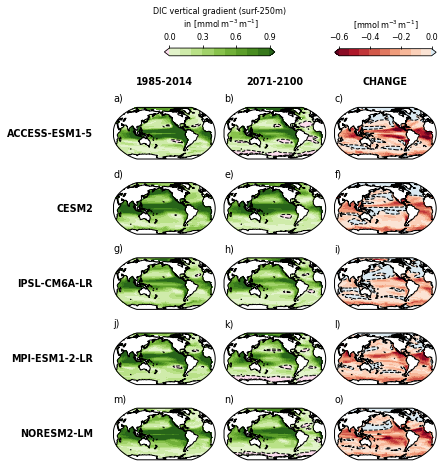

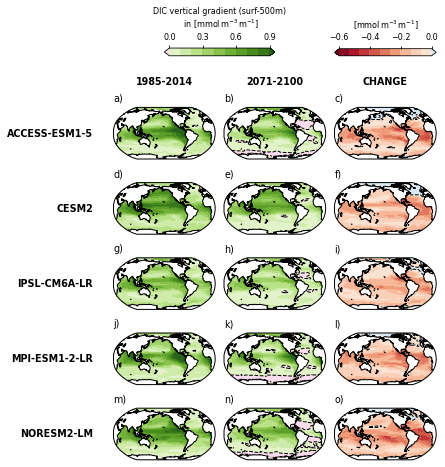

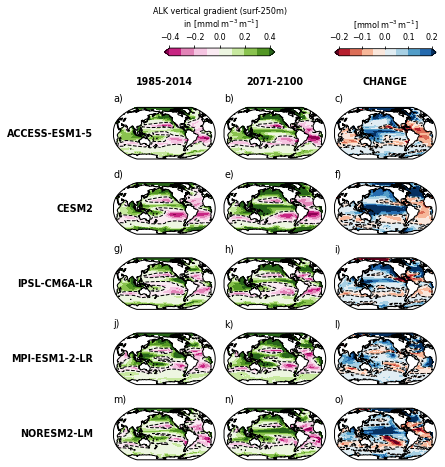

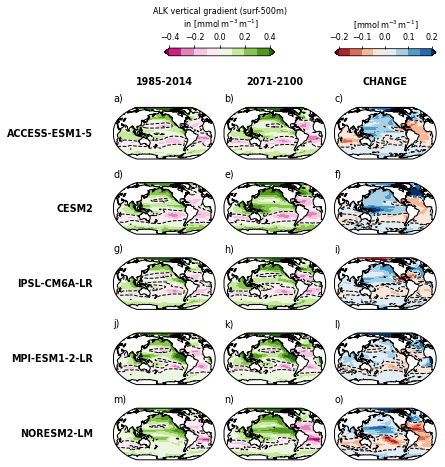

In [64]:
%%time
print(datetime.datetime.now())
print('Maps of changes in vertical gradient of DIC and ALK: plot')

for vvar in var_list: 
    for vgrad_depth in grad_depth_list: 
        
        #-----------------
        # FIGURE PARAM
        #-----------------

        nrow = len(model_list)
        ncol = 3
        fsize = (12*cm2in, 14*cm2in) # width height
        ccrsproj = ccrs.Robinson(central_longitude=-155)
        fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                               subplot_kw=dict(projection=ccrsproj),
                               squeeze = False)

        subnum = list('abcdefghijklmnopqrstuvwxyz')
        aaa=[]
        for sss in subnum: aaa.append('a'+sss)
        subnum=subnum+aaa
        subnum.reverse()

        #-----------------
        # CREATE CUSTOM CMAP AND KEYWORDS DICT
        #-----------------

        if vvar=='dissic': 

            #_________
            # cmap

            nbcolors = 9
            
            zw = cm.get_cmap('PiYG', 256)
            aa = zw(np.linspace(0, 1, 2*nbcolors+2+4))[nbcolors+1+4:]
            bb = zw(np.linspace(0, 1, 2*nbcolors+2+4))[nbcolors]
            cmap1 = ListedColormap(aa[:-1])
            cmap1.set_under(color = bb)
            cmap1.set_over(color  = aa[-1])
            cmap1.set_bad(color   = 'silver', alpha=0)

            zw = cm.get_cmap('RdBu', 256)
            aa = zw(np.linspace(0, 1, 2*nbcolors+2+2))[:nbcolors+1]
            bb = zw(np.linspace(0, 1, 2*nbcolors+2+2))[nbcolors+1+2]
            cmap2 = ListedColormap(aa[1:])
            cmap2.set_under(color = aa[0])
            cmap2.set_over(color  = bb)
            cmap2.set_bad(color   = 'silver', alpha=0)

            #_________
            # kwmap

            kwmap1 = {'vmin':0, 'vmax':.9, 'cmap':cmap1, \
                     'transform':ccrs.PlateCarree() }

            kwmap2 = {'vmin':-.6, 'vmax':0, 'cmap':cmap2, \
                     'transform':ccrs.PlateCarree() }

            cbticks1 = np.linspace( kwmap1['vmin'], kwmap1['vmax'], np.int(cmap1.colors.shape[0]/3+1) )
            cbticks2 = np.linspace( kwmap2['vmin'], kwmap2['vmax'], np.int(cmap2.colors.shape[0]/3+1) )
            
        elif vvar=='talk': 

            #_________
            # cmap

            zw = cm.get_cmap('PiYG', 256)
            aa = zw(np.linspace(0, 1, 10))
            cmap1 = ListedColormap(aa[1:-1])
            cmap1.set_under(color = aa[0])
            cmap1.set_over(color  = aa[-1])
            cmap1.set_bad(color   = 'silver', alpha=0)

            zw = cm.get_cmap('RdBu', 256)
            aa = zw(np.linspace(0, 1, 10))
            cmap2 = ListedColormap(aa[1:-1])
            cmap2.set_under(color = aa[0])
            cmap2.set_over(color  = aa[-1])
            cmap2.set_bad(color   = 'silver', alpha=0)

            #_________
            # kwmap

            kwmap1 = {'vmin':-.4, 'vmax':.4, 'cmap':cmap1, \
                     'transform':ccrs.PlateCarree() }

            kwmap2 = {'vmin':-.2, 'vmax':.2, 'cmap':cmap2, \
                     'transform':ccrs.PlateCarree() }
            cbticks1 = np.linspace( kwmap1['vmin'], kwmap1['vmax'], np.int(cmap1.colors.shape[0]/2+1) )
            cbticks2 = np.linspace( kwmap2['vmin'], kwmap2['vmax'], np.int(cmap2.colors.shape[0]/2+1) )
        else: exit('Wrong vvar')
            
        kwcont = dict(levels=[0], colors='k', linewidths=1., linestyles='--', transform=ccrs.PlateCarree())
        
        #---------------------
        # MAPS
        #---------------------

        pcm = np.zeros_like(ax)
        for imodel, vmodel in enumerate(model_list): 

            zwsaved = {}
            for iperiod, vperiod in enumerate(period_list): 

                #____________
                # Load datas

                fname = data2plot_dir_dict[vvar]+vvar+'_'+vmodel+'_'+vperiod+'_Grad'+vgrad_depth+'.txt'
                zw = read_grad_dic_datas(fname)

                if   vgrad_depth == 'surf-500m' : ddd = 500.
                elif vgrad_depth == 'surf-250m' : ddd = 250.
                else: exit('grad_depth not correct')

                X = zw[2]
                Y = zw[1]
                Z = -zw[0]/ddd

                zwsaved[vperiod] = Z

                #____________
                # Plot

                zax = ax[imodel, iperiod]
                pcm[imodel, iperiod] = zax.pcolormesh(X, Y, Z, **kwmap1)   
                zax.contour(X, Y, Z, **kwcont)
                zax.coastlines()

            #

            #____________
            # Plot delta

            zax = ax[imodel, iperiod+1]
            Z = zwsaved[period_list[1]] - zwsaved[period_list[0]]
            pcm[imodel, iperiod+1] = zax.pcolormesh(X, Y, Z, **kwmap2)  
            zax.contour(X, Y, Z, **kwcont)
            zax.coastlines()

        #

        fig.tight_layout()

        #---------------------
        # Add numbering to titles of subplots
        #---------------------

        for irow, axrow in enumerate(ax): 
            for icol, zax in enumerate(axrow): 
                zwtitle = subnum.pop() + ')'
                zax.set_title(zwtitle, loc='left')
            #
        #

        #---------------------
        # Colorbar
        #---------------------

        zw1 = ax[0, 0].get_position()
        zw2 = ax[0, 1].get_position()
        nx0 = zw1.x0 + .5*zw1.width
        ny0 = zw1.y1 + 1*zw1.height
        nw  = zw2.x1 - .5*zw2.width - nx0
        nh  = 0.06*nw
        cax = fig.add_axes([nx0, ny0, nw, nh])
        zwlab = '%s vertical gradient (%s)\n in [mmol$\,$m$^{-3}\,$m$^{-1}$]' %(namevar_dict[vvar], vgrad_depth)
        cbar = fig.colorbar(pcm[0, 0], cax=cax, ticklocation='top', 
                            orientation='horizontal', extend='both', 
                            label = zwlab)
        cbar.set_ticks( cbticks1 )

        zw1 = ax[0, -1].get_position()
        nx0 = zw1.x0 
        ny0 = zw1.y1 + 1*zw1.height
        nw  = zw1.width
        nh  = 0.06*nw
        cax = fig.add_axes([nx0, ny0, nw, nh])
        zwlab = '[mmol$\,$m$^{-3}\,$m$^{-1}$]'
        cbar = fig.colorbar(pcm[0, -1], cax=cax, ticklocation='top', 
                            orientation='horizontal', extend='both', 
                            label = zwlab)
        cbar.set_ticks( cbticks2 )


        #---------------------
        # Add text on the left: model names
        #---------------------

        kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='right', va='center')
        for imodel, vmodel in enumerate(model_list): 
            zw1 = ax[imodel, 0].get_position()
            ny0 = 0.5 *(zw1.y0+zw1.y1)
            nx0 = zw1.x0 - .2*zw1.width
            fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
        #

        #---------------------
        # Add text on the top: period names
        #---------------------

        kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='center', va='bottom')
        for iperiod, vperiod in enumerate(period_list): 
            zw1 = ax[0, iperiod].get_position()
            nx0 = 0.5 *(zw1.x0+zw1.x1)
            ny0 = zw1.y1 + .4*zw1.height
            fig.text(nx0, ny0, vperiod.upper(), **kwtxt)
        #
        iperiod, vperiod = 2, 'Change'
        zw1 = ax[0, iperiod].get_position()
        nx0 = 0.5 *(zw1.x0+zw1.x1)
        ny0 = zw1.y1 + .4*zw1.height
        fig.text(nx0, ny0, vperiod.upper(), **kwtxt)

        #---------------------
        # Save figure
        #---------------------

        fignam = 'maps-gradz-'+namevar_dict[vvar].lower()+'-'+vgrad_depth.lower()+'.png'
        fig.savefig(dirout+fignam, bbox_inches='tight')
        print('Figure saved: '+fignam)

    #
#


# ca. 1m

## Plot summary

2022-12-05 21:32:44.604610
Maps of changes in vertical gradient of DIC and ALK: plot summary
Figure saved: maps-gradz-alk-dic-summary.png
CPU times: user 24.7 s, sys: 2.6 s, total: 27.3 s
Wall time: 20.1 s


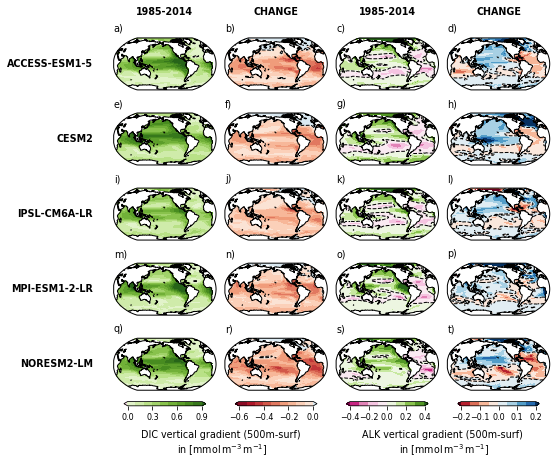

In [93]:
%%time
print(datetime.datetime.now())
print('Maps of changes in vertical gradient of DIC and ALK: plot summary')

vgrad_depth = 'surf-500m'
gradname = '500m-surf'

#-----------------
# FIGURE PARAM
#-----------------

nrow = len(model_list)
ncol = 4
fsize = (16*cm2in, 14*cm2in) # width height
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# CREATE CUSTOM CMAP AND KEYWORDS DICT
#-----------------

kwmap1, kwmap2 = {}, {}
cbticks1, cbticks2 = {}, {}
for ivar, vvar in enumerate(var_list): 

    if vvar=='dissic': 

        #_________
        # cmap

        nbcolors = 9

        zw = cm.get_cmap('PiYG', 256)
        aa = zw(np.linspace(0, 1, 2*nbcolors+2+4))[nbcolors+1+4:]
        bb = zw(np.linspace(0, 1, 2*nbcolors+2+4))[nbcolors]
        cmap1 = ListedColormap(aa[:-1])
        cmap1.set_under(color = bb)
        cmap1.set_over(color  = aa[-1])
        cmap1.set_bad(color   = 'silver', alpha=0)

        zw = cm.get_cmap('RdBu', 256)
        aa = zw(np.linspace(0, 1, 2*nbcolors+2+2))[:nbcolors+1]
        bb = zw(np.linspace(0, 1, 2*nbcolors+2+2))[nbcolors+1+2]
        cmap2 = ListedColormap(aa[1:])
        cmap2.set_under(color = aa[0])
        cmap2.set_over(color  = bb)
        cmap2.set_bad(color   = 'silver', alpha=0)

        #_________
        # kwmap

        kwmap1[vvar] = {'vmin':0, 'vmax':.9, 'cmap':cmap1, \
                        'transform':ccrs.PlateCarree() }

        kwmap2[vvar] = {'vmin':-.6, 'vmax':0, 'cmap':cmap2, \
                        'transform':ccrs.PlateCarree() }

        cbticks1[vvar] = np.linspace( kwmap1[vvar]['vmin'], kwmap1[vvar]['vmax'], np.int(cmap1.colors.shape[0]/3+1) )
        cbticks2[vvar] = np.linspace( kwmap2[vvar]['vmin'], kwmap2[vvar]['vmax'], np.int(cmap2.colors.shape[0]/3+1) )

    elif vvar=='talk': 

        #_________
        # cmap

        zw = cm.get_cmap('PiYG', 256)
        aa = zw(np.linspace(0, 1, 10))
        cmap1 = ListedColormap(aa[1:-1])
        cmap1.set_under(color = aa[0])
        cmap1.set_over(color  = aa[-1])
        cmap1.set_bad(color   = 'silver', alpha=0)

        zw = cm.get_cmap('RdBu', 256)
        aa = zw(np.linspace(0, 1, 10))
        cmap2 = ListedColormap(aa[1:-1])
        cmap2.set_under(color = aa[0])
        cmap2.set_over(color  = aa[-1])
        cmap2.set_bad(color   = 'silver', alpha=0)

        #_________
        # kwmap

        kwmap1[vvar] = {'vmin':-.4, 'vmax':.4, 'cmap':cmap1, \
                        'transform':ccrs.PlateCarree() }
        kwmap2[vvar] = {'vmin':-.2, 'vmax':.2, 'cmap':cmap2, \
                        'transform':ccrs.PlateCarree() }
        cbticks1[vvar] = np.linspace( kwmap1[vvar]['vmin'], kwmap1[vvar]['vmax'], np.int(cmap1.colors.shape[0]/2+1) )
        cbticks2[vvar] = np.linspace( kwmap2[vvar]['vmin'], kwmap2[vvar]['vmax'], np.int(cmap2.colors.shape[0]/2+1) )
    else: exit('Wrong vvar')
#
kwcont = dict(levels=[0], colors='k', linewidths=1., linestyles='--', transform=ccrs.PlateCarree())

#---------------------
# MAPS
#---------------------

pcm = np.zeros_like(ax)
for ivar, vvar in enumerate(var_list): 
        
    for imodel, vmodel in enumerate(model_list): 

        if   vgrad_depth == 'surf-500m' : ddd = 500.
        elif vgrad_depth == 'surf-250m' : ddd = 250.
        else: exit('grad_depth not correct')
        
        #____________
        # Load datas
    
        vperiod = '1985-2014'
        fname = data2plot_dir_dict[vvar]+vvar+'_'+vmodel+'_'+vperiod+'_Grad'+vgrad_depth+'.txt'
        zw = read_grad_dic_datas(fname)
        X = zw[2]
        Y = zw[1]
        Zhist = -zw[0]/ddd
        vperiod = '2071-2100'
        fname = data2plot_dir_dict[vvar]+vvar+'_'+vmodel+'_'+vperiod+'_Grad'+vgrad_depth+'.txt'
        zw = read_grad_dic_datas(fname)
        Zchange = -zw[0]/ddd - Zhist

        #____________
        # Plot

        iperiod = 0 + 2*ivar
        zax = ax[imodel, iperiod]
        pcm[imodel, iperiod] = zax.pcolormesh(X, Y, Zhist, **kwmap1[vvar])   
        zax.contour(X, Y, Zhist, **kwcont)
        zax.coastlines()

        iperiod = 1 + 2*ivar
        zax = ax[imodel, iperiod]
        pcm[imodel, iperiod] = zax.pcolormesh(X, Y, Zchange, **kwmap2[vvar])  
        zax.contour(X, Y, Zchange, **kwcont)
        zax.coastlines()

    #
#

fig.tight_layout()

#---------------------
# Add numbering to titles of subplots
#---------------------

for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow): 
        zwtitle = subnum.pop() + ')'
        zax.set_title(zwtitle, loc='left')
    #
#

#---------------------
# Colorbar
#---------------------

for ivar, vvar in enumerate(var_list): 
    
    iperiod = 2*ivar
    zw1 = ax[-1, iperiod].get_position()
    nx0 = zw1.x0 + .1*zw1.width
    ny0 = zw1.y0 - .3*zw1.height
    nw  = .8*zw1.width 
    nh  = 0.06*nw
    cax = fig.add_axes([nx0, ny0, nw, nh])
    cbar = fig.colorbar(pcm[0, iperiod], cax=cax, ticklocation='bottom', 
                        orientation='horizontal', extend='both')
    cbar.set_ticks( cbticks1[vvar] )

    iperiod = 2*ivar+1
    zw1 = ax[-1, iperiod].get_position()
    nx0 = zw1.x0 + .1*zw1.width
    ny0 = zw1.y0 - .3*zw1.height
    nw  = .8*zw1.width 
    nh  = 0.06*nw
    cax = fig.add_axes([nx0, ny0, nw, nh])
    cbar = fig.colorbar(pcm[0, iperiod], cax=cax, ticklocation='bottom', 
                        orientation='horizontal', extend='both')
    cbar.set_ticks( cbticks2[vvar] )
    
    iperiod = 2*ivar
    zw1 = ax[-1, iperiod].get_position()
    iperiod = 2*ivar+1
    zw2 = ax[-1, iperiod].get_position()
    nx0 = 0.5*(zw1.x1 + zw2.x0)
    ny0 = zw1.y0 - 1.3*zw1.height
    kwtxt = dict(fontsize='large', rotation='horizontal', ha='center', va='bottom')
    zwlab = '%s vertical gradient (%s)\n in [mmol$\,$m$^{-3}\,$m$^{-1}$]' %(namevar_dict[vvar], gradname)
    fig.text(nx0, ny0, zwlab, **kwtxt)


#

#---------------------
# Add text on the left: model names
#---------------------

kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='right', va='center')
for imodel, vmodel in enumerate(model_list): 
    zw1 = ax[imodel, 0].get_position()
    ny0 = 0.5 *(zw1.y0+zw1.y1)
    nx0 = zw1.x0 - .2*zw1.width
    fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
#

#---------------------
# Add text on the top: period names
#---------------------

kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='center', va='bottom')

for ivar, vvar in enumerate(var_list): 

    iperiod, vperiod = 2*ivar, period_list[0]
    zw1 = ax[0, iperiod].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .4*zw1.height
    fig.text(nx0, ny0, vperiod.upper(), **kwtxt)

    iperiod, vperiod = 2*ivar+1, 'Change'
    zw1 = ax[0, iperiod].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .4*zw1.height
    fig.text(nx0, ny0, vperiod.upper(), **kwtxt)

#



#---------------------
# Save figure
#---------------------

fignam = 'maps-gradz-alk-dic-summary.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)


# ca. 1m

## Plot summary 2

2022-09-21 15:42:18.916015
Maps of changes in vertical gradient of DIC and ALK: plot summary 2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: divide by zero encountered in true_divide


Figure saved: maps-gradz-alk-dic-summary-2.png
CPU times: user 30 s, sys: 4.09 s, total: 34.1 s
Wall time: 24.9 s


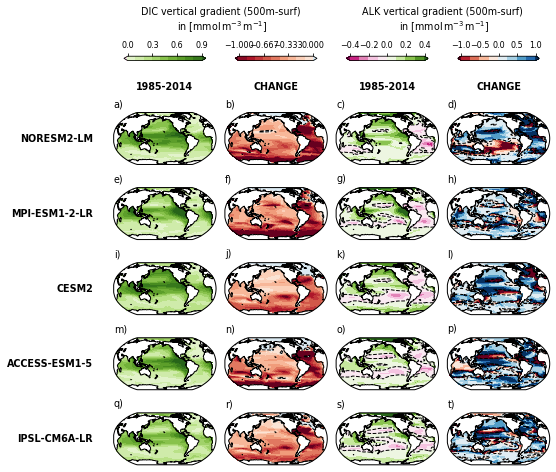

In [13]:
%%time
print(datetime.datetime.now())
print('Maps of changes in vertical gradient of DIC and ALK: plot summary 2')

vgrad_depth = 'surf-500m'
gradname = '500m-surf'

#-----------------
# FIGURE PARAM
#-----------------

nrow = len(model_list)
ncol = 4
fsize = (16*cm2in, 14*cm2in) # width height
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

subnum = list('abcdefghijklmnopqrstuvwxyz')
aaa=[]
for sss in subnum: aaa.append('a'+sss)
subnum=subnum+aaa
subnum.reverse()

#-----------------
# CREATE CUSTOM CMAP AND KEYWORDS DICT
#-----------------

kwmap1, kwmap2 = {}, {}
cbticks1, cbticks2 = {}, {}
for ivar, vvar in enumerate(var_list): 

    if vvar=='dissic': 

        #_________
        # cmap

        nbcolors = 9

        zw = cm.get_cmap('PiYG', 256)
        aa = zw(np.linspace(0, 1, 2*nbcolors+2+4))[nbcolors+1+4:]
        bb = zw(np.linspace(0, 1, 2*nbcolors+2+4))[nbcolors]
        cmap1 = ListedColormap(aa[:-1])
        cmap1.set_under(color = bb)
        cmap1.set_over(color  = aa[-1])
        cmap1.set_bad(color   = 'silver', alpha=0)

        zw = cm.get_cmap('RdBu', 256)
        aa = zw(np.linspace(0, 1, 2*nbcolors+2+2))[:nbcolors+1]
        bb = zw(np.linspace(0, 1, 2*nbcolors+2+2))[nbcolors+1+2]
        cmap2 = ListedColormap(aa[1:])
        cmap2.set_under(color = aa[0])
        cmap2.set_over(color  = bb)
        cmap2.set_bad(color   = 'silver', alpha=0)

        #_________
        # kwmap

        kwmap1[vvar] = {'vmin':0, 'vmax':.9, 'cmap':cmap1, \
                        'transform':ccrs.PlateCarree() }

        kwmap2[vvar] = {'vmin':-1., 'vmax':0., 'cmap':cmap2, \
                        'transform':ccrs.PlateCarree() }

        cbticks1[vvar] = np.linspace( kwmap1[vvar]['vmin'], kwmap1[vvar]['vmax'], np.int(cmap1.colors.shape[0]/3+1) )
        cbticks2[vvar] = np.linspace( kwmap2[vvar]['vmin'], kwmap2[vvar]['vmax'], np.int(cmap2.colors.shape[0]/3+1) )

    elif vvar=='talk': 

        #_________
        # cmap

        zw = cm.get_cmap('PiYG', 256)
        aa = zw(np.linspace(0, 1, 10))
        cmap1 = ListedColormap(aa[1:-1])
        cmap1.set_under(color = aa[0])
        cmap1.set_over(color  = aa[-1])
        cmap1.set_bad(color   = 'silver', alpha=0)

        zw = cm.get_cmap('RdBu', 256)
        aa = zw(np.linspace(0, 1, 10))
        cmap2 = ListedColormap(aa[1:-1])
        cmap2.set_under(color = aa[0])
        cmap2.set_over(color  = aa[-1])
        cmap2.set_bad(color   = 'silver', alpha=0)

        #_________
        # kwmap

        kwmap1[vvar] = {'vmin':-.4, 'vmax':.4, 'cmap':cmap1, \
                        'transform':ccrs.PlateCarree() }
        kwmap2[vvar] = {'vmin':-1, 'vmax':1, 'cmap':cmap2, \
                        'transform':ccrs.PlateCarree() }
        cbticks1[vvar] = np.linspace( kwmap1[vvar]['vmin'], kwmap1[vvar]['vmax'], np.int(cmap1.colors.shape[0]/2+1) )
        cbticks2[vvar] = np.linspace( kwmap2[vvar]['vmin'], kwmap2[vvar]['vmax'], np.int(cmap2.colors.shape[0]/2+1) )
    else: exit('Wrong vvar')
#
kwcont = dict(levels=[0], colors='k', linewidths=1., linestyles='--', transform=ccrs.PlateCarree())

#---------------------
# MAPS
#---------------------

pcm = np.zeros_like(ax)
for ivar, vvar in enumerate(var_list): 
        
    for imodel, vmodel in enumerate(model_list): 

        if   vgrad_depth == 'surf-500m' : ddd = 500.
        elif vgrad_depth == 'surf-250m' : ddd = 250.
        else: exit('grad_depth not correct')
        
        #____________
        # Load datas
    
        vperiod = '1985-2014'
        fname = data2plot_dir_dict[vvar]+vvar+'_'+vmodel+'_'+vperiod+'_Grad'+vgrad_depth+'.txt'
        zw = read_grad_dic_datas(fname)
        X = zw[2]
        Y = zw[1]
        Zhist = -zw[0]/ddd
        vperiod = '2071-2100'
        fname = data2plot_dir_dict[vvar]+vvar+'_'+vmodel+'_'+vperiod+'_Grad'+vgrad_depth+'.txt'
        zw = read_grad_dic_datas(fname)
        Zchange = (-zw[0]/ddd - Zhist)/Zhist

        #____________
        # Plot

        iperiod = 0 + 2*ivar
        zax = ax[imodel, iperiod]
        pcm[imodel, iperiod] = zax.pcolormesh(X, Y, Zhist, **kwmap1[vvar])   
        zax.contour(X, Y, Zhist, **kwcont)
        zax.coastlines()

        iperiod = 1 + 2*ivar
        zax = ax[imodel, iperiod]
        pcm[imodel, iperiod] = zax.pcolormesh(X, Y, Zchange, **kwmap2[vvar])  
        zax.contour(X, Y, Zchange, **kwcont)
        zax.coastlines()

    #
#

fig.tight_layout()

#---------------------
# Add numbering to titles of subplots
#---------------------

for irow, axrow in enumerate(ax): 
    for icol, zax in enumerate(axrow): 
        zwtitle = subnum.pop() + ')'
        zax.set_title(zwtitle, loc='left')
    #
#

#---------------------
# Colorbar
#---------------------

for ivar, vvar in enumerate(var_list): 
    
    iperiod = 2*ivar
    zw1 = ax[0, iperiod].get_position()
    nx0 = zw1.x0 + .1*zw1.width
    ny0 = zw1.y1 + 1*zw1.height
    nw  = .8*zw1.width 
    nh  = 0.06*nw
    cax = fig.add_axes([nx0, ny0, nw, nh])
    cbar = fig.colorbar(pcm[0, iperiod], cax=cax, ticklocation='top', 
                        orientation='horizontal', extend='both')
    cbar.set_ticks( cbticks1[vvar] )

    iperiod = 2*ivar+1
    zw1 = ax[0, iperiod].get_position()
    nx0 = zw1.x0 + .1*zw1.width
    ny0 = zw1.y1 + 1*zw1.height
    nw  = .8*zw1.width 
    nh  = 0.06*nw
    cax = fig.add_axes([nx0, ny0, nw, nh])
    cbar = fig.colorbar(pcm[0, iperiod], cax=cax, ticklocation='top', 
                        orientation='horizontal', extend='both')
    cbar.set_ticks( cbticks2[vvar] )
    
    iperiod = 2*ivar
    zw1 = ax[0, iperiod].get_position()
    iperiod = 2*ivar+1
    zw2 = ax[0, iperiod].get_position()
    nx0 = 0.5*(zw1.x1 + zw2.x0)
    ny0 = zw1.y1 + 1.5*zw1.height
    kwtxt = dict(fontsize='large', rotation='horizontal', ha='center', va='bottom')
    zwlab = '%s vertical gradient (%s)\n in [mmol$\,$m$^{-3}\,$m$^{-1}$]' %(namevar_dict[vvar], gradname)
    fig.text(nx0, ny0, zwlab, **kwtxt)


#

#---------------------
# Add text on the left: model names
#---------------------

kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='right', va='center')
for imodel, vmodel in enumerate(model_list): 
    zw1 = ax[imodel, 0].get_position()
    ny0 = 0.5 *(zw1.y0+zw1.y1)
    nx0 = zw1.x0 - .2*zw1.width
    fig.text(nx0, ny0, vmodel.upper(), **kwtxt)
#

#---------------------
# Add text on the top: period names
#---------------------

kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='center', va='bottom')

for ivar, vvar in enumerate(var_list): 

    iperiod, vperiod = 2*ivar, period_list[0]
    zw1 = ax[0, iperiod].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .4*zw1.height
    fig.text(nx0, ny0, vperiod.upper(), **kwtxt)

    iperiod, vperiod = 2*ivar+1, 'Change'
    zw1 = ax[0, iperiod].get_position()
    nx0 = 0.5 *(zw1.x0+zw1.x1)
    ny0 = zw1.y1 + .4*zw1.height
    fig.text(nx0, ny0, vperiod.upper(), **kwtxt)

#



#---------------------
# Save figure
#---------------------

fignam = 'maps-gradz-alk-dic-summary-2.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)


# ca. 1M

# Maps of predictors and cflux

## Inputs

In [68]:
%%time
print(datetime.datetime.now())
print('Maps of predictors and cflux: inputs')

model_list = ['ACCESS-ESM1-5', 'CESM2', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'NorESM2-LM']
simu_list  = ['historical', 'ssp126', 'ssp585']
predictor_list = ['fgco2', 'dissic', 'talk', 'tos', 'sfcWind', 'siconc', 'sos', 'po4']

feature_name = {
    'siconc' :'siconc', 
    'talk'   :'ALK',
    'dissic' :'DIC', 
    'tos'    :'SST', 
    'sfcWind':'sfcWind', 
    'sos'    :'SSS', 
    'po4'    :'PO4', 
    'atmco2' :'atmCO2',
    'fgco2'  :'CO$_2$ flux'
}
simu_name = {
    'picontrol': 'preindustrial', 
    'historical': 'historical', 
    'ssp126': 'SSP126', 
    'ssp585': 'SSP585'
}


2022-11-21 17:45:56.544424
Maps of predictors and cflux: inputs
CPU times: user 0 ns, sys: 587 µs, total: 587 µs
Wall time: 398 µs


## Prepare data2plot

In [67]:
%%time
print(datetime.datetime.now())
print('Maps of predictors and cflux: prepare data2plot')

data2plot = {}
for model in model_list:
    
    print('> model: '+model)
    data2plot[model]={}
    
    for simu in simu_list: 
    
        print('>> simu: '+simu)
        data2plot[model][simu] = {}
        
        for predictor in predictor_list: 
    
            data2plot[model][simu][predictor] = {}
        
            dirname = dircmip6 + model + '/' + simu + '/'
            fname = predictor + '_' + model + '_' + simu + '*.nc'
            dataset = xr.open_mfdataset(dirname + fname, use_cftime=True)
            print('File loaded: %s' %fname)
            zwpred = dataset[predictor].sel(time=slice('1850', '2100')).mean(dim='time').squeeze()

            zwX = zwpred['lon'].values
            zwY = zwpred['lat'].values
            zwZ = zwpred.values

            X, Y = np.meshgrid(zwX, zwY)
            
            data2plot[model][simu][predictor]['X'] = X
            data2plot[model][simu][predictor]['Y'] = Y
            data2plot[model][simu][predictor]['Z'] = zwZ
        #
    #
#

# ca. 2m30s

2022-11-21 17:43:08.321342
Maps of predictors and cflux: prepare data2plot
> model: ACCESS-ESM1-5
>> simu: historical
File loaded: fgco2_ACCESS-ESM1-5_historical*.nc
File loaded: dissic_ACCESS-ESM1-5_historical*.nc
File loaded: talk_ACCESS-ESM1-5_historical*.nc
File loaded: tos_ACCESS-ESM1-5_historical*.nc
File loaded: sfcWind_ACCESS-ESM1-5_historical*.nc
File loaded: siconc_ACCESS-ESM1-5_historical*.nc
File loaded: sos_ACCESS-ESM1-5_historical*.nc
File loaded: po4_ACCESS-ESM1-5_historical*.nc
>> simu: ssp126
File loaded: fgco2_ACCESS-ESM1-5_ssp126*.nc
File loaded: dissic_ACCESS-ESM1-5_ssp126*.nc
File loaded: talk_ACCESS-ESM1-5_ssp126*.nc
File loaded: tos_ACCESS-ESM1-5_ssp126*.nc
File loaded: sfcWind_ACCESS-ESM1-5_ssp126*.nc
File loaded: siconc_ACCESS-ESM1-5_ssp126*.nc
File loaded: sos_ACCESS-ESM1-5_ssp126*.nc
File loaded: po4_ACCESS-ESM1-5_ssp126*.nc
>> simu: ssp585
File loaded: fgco2_ACCESS-ESM1-5_ssp585*.nc
File loaded: dissic_ACCESS-ESM1-5_ssp585*.nc
File loaded: talk_ACCESS-ESM1-5

## Plot

2022-11-21 17:45:56.572609
Maps of predictors and cflux: plot
> model: ACCESS-ESM1-5
>> simu: historical
>> simu: ssp126
>> simu: ssp585
Figure saved: maps-predictors-ACCESS-ESM1-5.png
> model: CESM2
>> simu: historical
>> simu: ssp126
>> simu: ssp585
Figure saved: maps-predictors-CESM2.png
> model: IPSL-CM6A-LR
>> simu: historical
>> simu: ssp126
>> simu: ssp585
Figure saved: maps-predictors-IPSL-CM6A-LR.png
> model: MPI-ESM1-2-LR
>> simu: historical
>> simu: ssp126
>> simu: ssp585
Figure saved: maps-predictors-MPI-ESM1-2-LR.png
> model: NorESM2-LM
>> simu: historical
>> simu: ssp126
>> simu: ssp585
Figure saved: maps-predictors-NorESM2-LM.png
CPU times: user 3min, sys: 16.5 s, total: 3min 16s
Wall time: 2min 33s


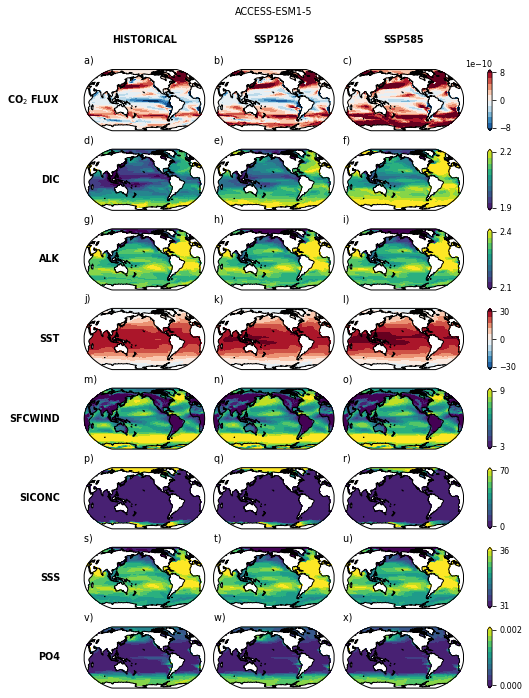

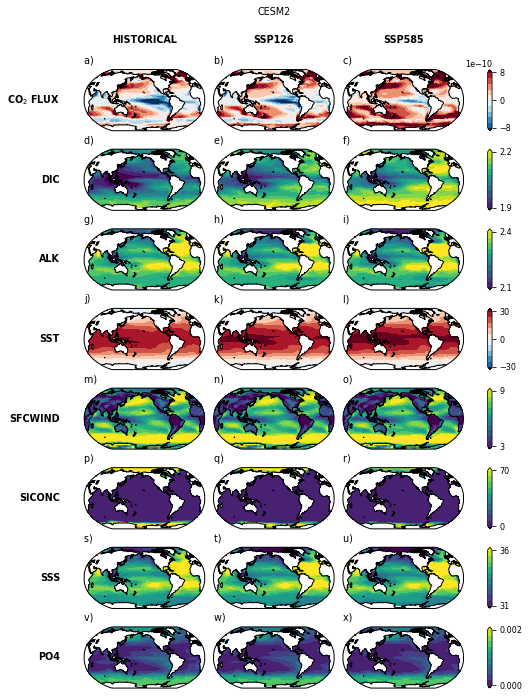

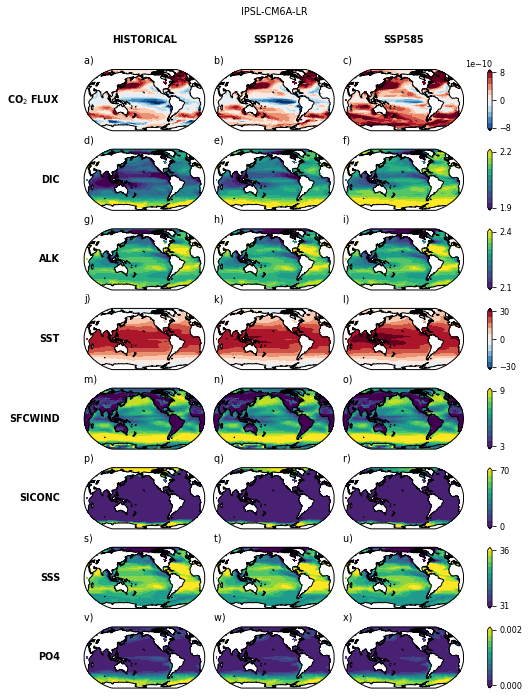

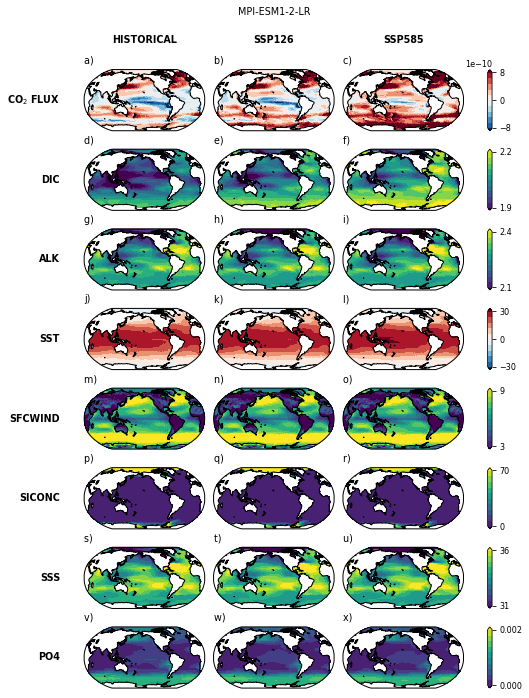

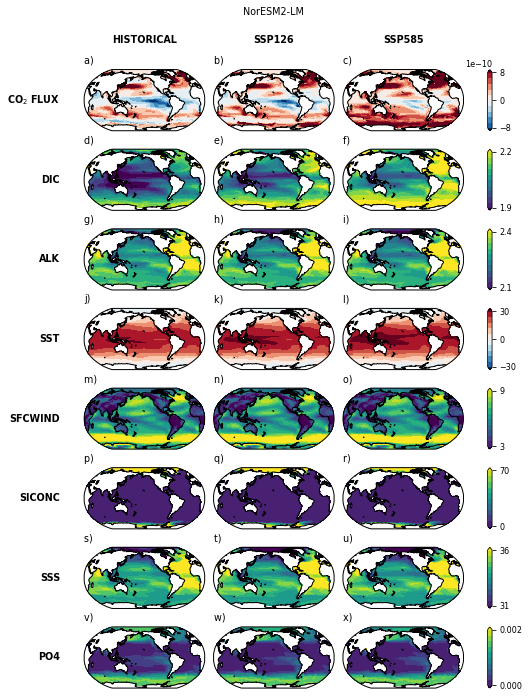

In [69]:
%%time
print(datetime.datetime.now())
print('Maps of predictors and cflux: plot')

# define vmin and vmax0
vmin, vmax = {}, {}
for pred in predictor_list: 
    zw = []
    for model in model_list: 
        for simu in simu_list: 
            zw.extend(data2plot[model][simu][pred]['Z'].flatten())
        #
    #
    zwvmin = np.nanquantile(zw, 0.1)
    zwvmax = np.nanquantile(zw, 0.9)
    if (zwvmin>=0) & (zwvmax>=0):
        ddd= zwvmax - zwvmin
        f=np.floor(np.log10(ddd))
        zwvmin = np.round(zwvmin*10**(-f))*10**f
        zwvmax = np.round(zwvmax*10**(-f))*10**f
        ddd= zwvmax - zwvmin
        if zwvmin < 0.1*ddd : zwvmin=0
    elif (zwvmin<0) & (zwvmax>=0): 
        zw = np.nanmax([np.abs(zwvmin), np.abs(zwvmax)])
        f=np.floor(np.log10(zw))
        zw = np.round(zw*10**(-f))*10**f
        zwvmin = -zw
        zwvmax=zw
    else: exit('check vmin and vmax')        
    vmin[pred] = zwvmin
    vmax[pred] = zwvmax
#

for imodel, vmodel in enumerate(model_list): 

    print('> model: '+vmodel)

    #-----------------
    # FIGURE PARAM
    #-----------------

    nrow = len(predictor_list)
    ncol = len(simu_list)
    fsize = (14*cm2in, 23*cm2in) # width height
    ccrsproj = ccrs.Robinson(central_longitude=-155)
    fig, ax = plt.subplots(nrow, ncol, figsize=fsize, 
                           subplot_kw=dict(projection=ccrsproj),
                           squeeze = False)

    subnum = list('abcdefghijklmnopqrstuvwxyz')
    aaa=[]
    for sss in subnum: aaa.append('a'+sss)
    subnum=subnum+aaa
    subnum.reverse()

    #-----------------
    # CREATE CUSTOM CMAP
    #-----------------

    zw = cm.get_cmap('viridis', 256)
    newcolors = zw(np.linspace(0, 1, 10+2))
    cmap1 = ListedColormap(newcolors[1:-1])
    cmap1.set_under(color=newcolors[0])
    cmap1.set_over (color=newcolors[-1])
    cmap1.set_bad(color='silver', alpha=0)

    zw = cm.get_cmap('RdBu_r', 256)
    newcolors = zw(np.linspace(0, 1, 10+2))
    cmap2 = ListedColormap(newcolors[1:-1])
    cmap2.set_under(color=newcolors[0])
    cmap2.set_over (color=newcolors[-1])
    cmap2.set_bad(color='silver', alpha=0)

    #-----------------
    # KEYWORDS DICT
    #-----------------

    kwmap1 = {'cmap':cmap1, \
             'transform':ccrs.PlateCarree() }

    kwmap2 = {'cmap':cmap2, \
             'transform':ccrs.PlateCarree() }

    #-----------------
    # Maps
    #-----------------

    mmm = np.zeros_like(ax)    
    for isimu, vsimu in enumerate(simu_list):

        print('>> simu: ' + vsimu)

        for ipred, vpred in enumerate(predictor_list): 
                        
            zax = ax[ipred, isimu]

            X = data2plot[vmodel][vsimu][vpred]['X']
            Y = data2plot[vmodel][vsimu][vpred]['Y']
            Z = data2plot[vmodel][vsimu][vpred]['Z']
            
            zwvmin, zwvmax = vmin[vpred], vmax[vpred]
            if (zwvmin>=0) & (zwvmax>=0):
                mmm[ipred, isimu] = zax.pcolormesh(X, Y, Z, vmin=zwvmin, vmax=zwvmax, **kwmap1)
            elif (zwvmin<0) & (zwvmax>=0): 
                mmm[ipred, isimu] = zax.pcolormesh(X, Y, Z, vmin=zwvmin, vmax=zwvmax, **kwmap2)
            else: exit('check vmin and vmax')
            zax.coastlines()

        #
    #
    fig.tight_layout()
    
    #---------------------
    # Add numbering to titles of subplots
    #---------------------

    for irow, axrow in enumerate(ax): 
        for zax in axrow: 
            zwtitle = subnum.pop() + ') '
            zax.set_title(zwtitle, loc='left')
        #
    #

    #---------------------
    # Colorbar
    #---------------------

    for ipred, vpred in enumerate(predictor_list): 
        
        zw1 = ax[ipred,  -1].get_position()
        nx0 = zw1.x1 + .2*zw1.width
        ny0 = zw1.y0
        nh  = zw1.height
        nw  = 0.12*nh
        cax = fig.add_axes([nx0, ny0, nw, nh])
        cbar = fig.colorbar(mmm[ipred, -1], cax=cax, ticklocation='right', 
                        orientation='vertical', extend='both')
        
        zwvmin, zwvmax = vmin[vpred], vmax[vpred]
        if (zwvmin>=0) & (zwvmax>=0):
            cbar.set_ticks([zwvmin, zwvmax])
        elif (zwvmin<0) & (zwvmax>=0): 
            cbar.set_ticks([zwvmin, 0, zwvmax])
        else: exit('check vmin and vmax')


    #---------------------
    # Add text on the left: feature names
    #---------------------

    kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='right', va='center')
    for ipred, vpred in enumerate(predictor_list): 
        zw1 = ax[ipred, 0].get_position()
        ny0 = 0.5 *(zw1.y0+zw1.y1)
        nx0 = zw1.x0 - .2*zw1.width
        fig.text(nx0, ny0, feature_name[vpred].upper(), **kwtxt)
    #

    #---------------------
    # Add text on the top: simu names
    #---------------------

    kwtxt = dict(fontsize='large', rotation='horizontal', weight='bold', ha='center', va='bottom')
    for isimu, vsimu in enumerate(simu_list): 
        zw1 = ax[0, isimu].get_position()
        nx0 = 0.5 *(zw1.x0+zw1.x1)
        ny0 = zw1.y1 + .4*zw1.height
        fig.text(nx0, ny0, simu_name[vsimu].upper(), **kwtxt)
    #

    fig.suptitle(vmodel, y=1.07)
    
    #---------------------
    # Save figure
    #---------------------

    fignam = 'maps-predictors-'+vmodel+'.png'
    fig.savefig(dirout+fignam, bbox_inches='tight')
    print('Figure saved: '+fignam)

#

# ca. 2m30s